**Задача проекта**  

На основании имеющихся данных подготовить аналитический отчет, который в дальнейшем поможет продюсерам образовательных программ эффективно выстраивать стратегию по обновлению и улучшению курсов.  
В начале отчета оформлен емкий описательный блок по каждому курсу на основании рассчитанных показателей. Далее – посчитана потенциальная нагрузку на преподавателей, чтобы оценить необходимость расширения штата сотрудников. Затем идет блок из двух пунктов по анализу качества контента курсов, где необходимо выявить проблемные модули, которые, возможно, требуют доработки. Также стоит задача выявить потенциальную сезонность.


## Описание данных

In [1]:
#импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import dateutil.relativedelta
import calendar
from IPython.display import display, Image
import matplotlib.dates as mdates


%matplotlib inline

**Задание-подготовка:**
Объедините датасеты (кроме `students.scv`) в один общий для дальнейшей работы.

In [2]:
#готовим основной датасет, объединив 4 файла csv (кроме students.csv). Файл progress_phases.csv основной, поэтому объединение 
# начала с него.

#читаем csv файлы и преобразуем в DataFrame
#чтобы после объединения не было 2-х колонок с одинаковыми значениями, необходимо, чтобы в 2 файлах были колонки с одинаковыми 
# заголовками, поэтому в некоторых файлах производим переименование столбца
progress_phases = pd.read_csv('progress_phases.csv', encoding = 'utf-8') 

progresses = pd.read_csv('progresses.csv', encoding = 'utf-8') \
                .rename(columns = {'id':'progress_id'})

course_contents = pd.read_csv('course_contents.csv',encoding = 'utf-8')

courses = pd.read_csv('courses.csv',encoding = 'utf-8') \
            .rename(columns = {'id':'course_id'})

#объединяем 2 файла: параметр how равен left, т.к. необходимо взять все значения из 1го файла, а из 2го лишь то, что есть в 1м
progress_phases_progresses = pd.merge(progress_phases, progresses, how = 'left')

courses_contents = pd.merge(course_contents, courses, how = 'left') \
                     .drop('Unnamed: 0', axis = 'columns')  #удаляем ненужный столбик

#финальный датасет
main = pd.merge(progress_phases_progresses, courses_contents, how = 'left') 

main[main.is_homework == True].head()

,progress_id,module_number,lesson_number,status,start_date,finish_date,student_id,course_id,module_title,lesson_title,lesson_token,is_video,is_homework,title,field
4,a387ab916f402cb3fbfffd29f68fd0ce,1,6,done,2018-06-21 19:10:36.957891+00,2018-06-28 15:59:25.320418+00,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True,Веб-дизайн PRO 2.0,Design
7,a387ab916f402cb3fbfffd29f68fd0ce,2,5,start,2018-06-23 08:31:00.338883+00,NaN,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Концептуальный дизайн,Домашняя работа,90c5f618-e9f3-4af8-96ab-f41b312bfa77,False,True,Веб-дизайн PRO 2.0,Design
12,a97393fe164b448e7231c07d48c82f9e,2,6,start,2018-03-11 14:14:44.814222+00,NaN,f69e2707b7ba94d49ca03ea9ed52ea5d,bf27a4bf4ada4c756451703ea62a914f,Исследование целевой аудитории: портретировани...,Домашняя работа,bae729ef-e399-4ed8-a62b-c8195ed754aa,False,True,Интернет-маркетолог от Ingate,Marketing
17,a97393fe164b448e7231c07d48c82f9e,1,7,done,2018-02-19 12:30:34.638431+00,2018-02-20 09:16:50.297369+00,f69e2707b7ba94d49ca03ea9ed52ea5d,bf27a4bf4ada4c756451703ea62a914f,"Введение в интернет-маркетинг: цели, инструмен...",Домашняя работа,148dd02b-c203-4d35-a8a5-daf33fc02a82,False,True,Интернет-маркетолог от Ingate,Marketing
29,000962791295398b5ec7bc24f05269ac,7,5,done,2018-10-02 19:41:04.983571+00,2018-10-05 17:02:51.913911+00,fcd7b6853c2582372980dd6af56d3bdc,e3a0df907589d56692b5cb561fd90d87,Основы работы с графикой,Домашняя работа,e362bb6e-4ab4-4533-985e-d728300e4c32,False,True,Веб-дизайн с нуля 2.0,Design


**Задание 1.1.1**: найти общее количество курсов в датасете

In [3]:
#общее количество курсов в датасете считаю при помощи функции unique из библиотеки numpy
total_courses = len(np.unique(main['title'])) 
total_courses

15

**Задание 1.1.2**: найти количество модулей на каждом курсе

In [4]:
#в исходном датасете указаны номера модулей. Следовательно, найдя максимальный номер модуля, мы узнаем, сколько всего 
#модулей на курсе

modules_by_courses = main.groupby('title')['module_number'].agg ('max')
modules_by_courses

title
Excel Базовый                           9
Java-разработчик                       17
Java-разработчик c нуля                 9
JavaScript с нуля                      18
PHP-разработчик с 0 до PRO. Часть 1     8
SMM-маркетолог от А до Я               11
UX-дизайн                              20
Анимация интерфейсов                   21
Веб-вёрстка для начинающих 2.0          8
Веб-дизайн PRO 2.0                     17
Веб-дизайн Базовый                     17
Веб-дизайн с нуля 2.0                  19
Веб-разработчик                        20
Интернет-маркетолог от Ingate          18
Руководитель digital-проектов          17
Name: module_number, dtype: int64

**Задание 1.1.3**: найти количество уроков в каждом модуле на каждом курсе

In [5]:
#Аналогично заданию 1.2: при нахождении количества уроков в модуле ориентируемся на максимальный номер модуля
lesson_number = main.groupby (['title','module_title'])['lesson_number'].agg ('max')
lesson_number

title                          module_title                                       
Excel Базовый                   Визуализация данных Excel                              5
                               Основной функционал Excel                              11
                               Основной функционал Excel (продолжение)                 7
                               Сводные таблицы Excel                                   5
                               Формулы и функции Excel. Более сложные формулы          5
                                                                                      ..
Руководитель digital-проектов  Решение факапов. Lean/TOC. Обзор.                       5
                               Требовательность digital-продюсера                      4
                               Управление временем                                     4
                               Управление дизайнерами. Разработка дизайна по scrum     7
                           

**Задание 1.1.4**: найти медианное количество уроков в модуле на каждом курсе  
*Примечание от автора*: насколько я понимаю, необходимо найти медианное значение урока, к которому приступили студенты

In [6]:
median_lesson = main.groupby (['title','module_title'])['lesson_number'].agg ('median').astype('int')
median_lesson

title                          module_title                                       
Excel Базовый                   Визуализация данных Excel                             3
                               Основной функционал Excel                              5
                               Основной функционал Excel (продолжение)                4
                               Сводные таблицы Excel                                  3
                               Формулы и функции Excel. Более сложные формулы         3
                                                                                     ..
Руководитель digital-проектов  Решение факапов. Lean/TOC. Обзор.                      3
                               Требовательность digital-продюсера                     2
                               Управление временем                                    2
                               Управление дизайнерами. Разработка дизайна по scrum    4
                               Эколог

**Задание 1.1.5**: найти количество учеников на каждом курсе

In [7]:
#удаляем дубликаты, так как внутри одного курса несколько модулей, на которые могут быть записаны одни и те же студенты;
#группируем датасет по названию курса и применяем агрегирующую функцию count;
#сортируем по убыванию. Примечание: столбик field необходим для задания 1.3

student_number = main.loc[:, ['title', 'student_id', 'field']] \
                .drop_duplicates() \
                .groupby(['title', 'field']) \
                .agg('count') \
                .sort_values('student_id', ascending = False) \
                .reset_index()

student_number

,title,field,student_id
0,Интернет-маркетолог от Ingate,Marketing,2168
1,Веб-дизайн с нуля 2.0,Design,2014
2,Веб-вёрстка для начинающих 2.0,Development,2004
3,Веб-дизайн PRO 2.0,Design,1711
4,UX-дизайн,Design,1151
5,JavaScript с нуля,Development,966
6,PHP-разработчик с 0 до PRO. Часть 1,Development,854
7,Excel Базовый,Business,782
8,Java-разработчик,Development,763
9,Руководитель digital-проектов,Business,685


**Задание 1.1.6**: найти минимальный, максимальный, средний, медианный возраст студентов

In [8]:
#готовим датасет
students = pd.read_csv('students.csv', encoding = 'utf-8')
students_main = main.loc[:, ['title', 'student_id']].drop_duplicates()
students = pd.merge(students_main, students, how = 'left', left_on = 'student_id', right_on = 'id')
students = students.loc [:, ['student_id', 'birthday']].dropna() #избавляемся от пустых значений

#столбик с датой рождения приводим к типу datetime64
students['birthday'] = students['birthday'].map(lambda x: np.datetime64(x))

#фильтруем таблицу:избавляемся от битых дат; я избавилась от слишком "молодых" и "взрослых студентов", так как иначе 
#максимальный возраст получается 100 лет, а минимальный 1 год.
students = students[students['birthday'].map (lambda x: np.datetime64(x, 'Y') > np.datetime64('1970-01-01',  'Y') 
                                              and np.datetime64(x, 'Y') < np.datetime64('2000-01-01',  'Y'))] 
                                               
#записываем сегодняшнюю дату в переменную today            
today = np.datetime64 ('today') 

#считаем возраст студентов
students['age'] = students['birthday'].map (lambda x: (today - x)/np.timedelta64(365, 'D'))

#считаем метрики возраста: максимум, минимум, среднее, медиану при помощи метода describe()
student_age_metrics=students['age'].describe()[['max', 'min', 'mean', '50%']].astype('int')

student_age_metrics

max     49
min     20
mean    30
50%     30
Name: age, dtype: int32

**Задание 1.1.7**: найти минимальный, максимальный, средний, медианный возраст студентов на каждом курсе

In [9]:
#формируем датасет
students_main = main.loc[:, ['title', 'student_id']].drop_duplicates()
students_main = pd.merge(students_main, students, how = 'left', on = 'student_id')

#рассчитываем max, min, mean и median возраст на каждом курсе
students_main=students_main.loc[:,['title', 'age']].groupby('title').agg(['max', 'min', 'mean', 'median'])

students_main.astype('int')

age                
                                    max min mean median
title                                                  
Excel Базовый                        49  21   34     34
Java-разработчик                     49  21   31     30
Java-разработчик c нуля              49  21   31     30
JavaScript с нуля                    49  20   29     29
PHP-разработчик с 0 до PRO. Часть 1  49  20   30     29
SMM-маркетолог от А до Я             49  20   30     29
UX-дизайн                            49  20   30     30
Анимация интерфейсов                 49  20   30     30
Веб-вёрстка для начинающих 2.0       49  20   30     29
Веб-дизайн PRO 2.0                   49  20   29     28
Веб-дизайн Базовый                   48  21   30     29
Веб-дизайн с нуля 2.0                49  20   29     28
Веб-разработчик                      48  21   29     29
Интернет-маркетолог от Ingate        49  20   32     31
Руководитель digital-проектов        48  21   32     32

**Задание 1.2**: построить bar-chart, отражающий количество студентов на каждом курсе. Ticks нужно развернуть так, чтобы они были читаемы

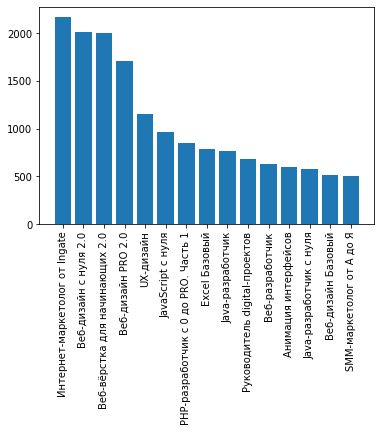

In [10]:
#создаем полотно для графика
fig,subplot = plt.subplots()

#переворачиваем подписи оси Х
plt.xticks(np.arange(total_courses), rotation='vertical', labels=student_number['title'])

#строим гистограмму
plt.bar(student_number['title'], student_number['student_id'].values)

#показываем график
plt.show()

**Задание 1.3**: Постройте горизонтальный (столбцы должны располагаться горизонтально) bar-chart, отражающий количество студентов на каждом курсе. График должен иметь заголовок. Значения должны быть отсортированы. Цвет столбцов должен содержать информацию о сфере, к которой относится курс (то есть нужна легенда). Прозрачность должна стоять на отметке 0.1. На график должна быть нанесена линия медианы. У медианы должен быть свой цвет. Рамки у графика быть не должно

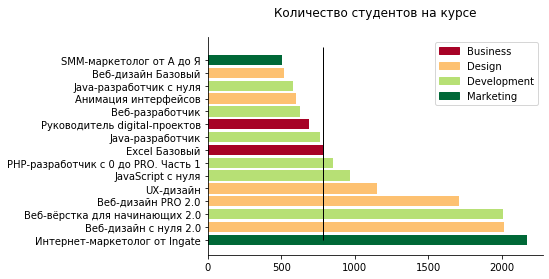

In [73]:
#формируем данные для легенды: категории курсов и цвета для каждой категории
fields = np.unique(main['field'])
colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.005, 0.999, len(fields)))

#создаем словарь, где key = наименование категории курса, value - цвет
category = dict(zip(fields, colors))

#создаем массив, который хранит цвета в зависимости от категории для каждого курса
c = student_number['field'].apply(lambda x: category[x])

#создаем полотно для графика
fig,subplot = plt.subplots()

#устанавливаем название графика и подписи оси y
subplot.set_title('Количество студентов на курсе\n')
plt.yticks(np.arange(total_courses), labels=student_number['title'])

#убираем правую и верхнюю границы графика
subplot.spines['right'].set_visible(False)
subplot.spines['top'].set_visible(False)

#рисуем горизонтальную столбчатую диаграму и наносим медиану
plt.barh(student_number['title'], student_number['student_id'], color = c)
plt.vlines(student_number['student_id'].median(), -0, total_courses, linewidth = 1)

#формируем подписи для легенды и саму легенду
legend_labels = list(category.keys())
handles = [plt.Rectangle((0,0),1,1, color=category[label]) for label in legend_labels]
plt.legend(handles, legend_labels)

plt.savefig('Количество студентов на курсе.png', bbox_inches='tight') #сохраним для отчета в задании 1.4

plt.show()

### Описательный блок

**Задание 1.4**: На основании рассчитанных значений опишите данные (описание должно быть полным и покрывать все полученные выше метрики)

Общее количество предлагаемых к прохождению курсов составляет 15. Количество студентов и названия курсов представлены в 
таблице ниже.

title
Интернет-маркетолог от Ingate          2168
Веб-дизайн с нуля 2.0                  2014
Веб-вёрстка для начинающих 2.0         2004
Веб-дизайн PRO 2.0                     1711
UX-дизайн                              1151
JavaScript с нуля                       966
PHP-разработчик с 0 до PRO. Часть 1     854
Excel Базовый                           782
Java-разработчик                        763
Руководитель digital-проектов           685
Веб-разработчик                         628
Анимация интерфейсов                    598
Java-разработчик c нуля                 581
Веб-дизайн Базовый                      518
SMM-маркетолог от А до Я                506
Name: student_id, dtype: int64

Насколько видно из таблицы, курсы, в основном, относятся к IT индустрии, быстро развивающейся в настоящее время.
Наиболее популярным курсом среди студентов, согласно 

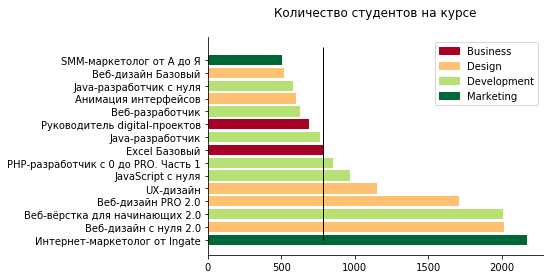

Насколько видно из диаграммы, преобладающий по количеству студентов курс относится к сфере Marketing. 
Более того, больше всего курсов представлено по таким сферам, как Development и Design.

*****************************************************************************************************************************

Каждый курс состоит из нескольких модулей. Ниже представлена таблица c общим количество модулей на каждом курсе.

title
Анимация интерфейсов                   21
Веб-разработчик                        20
UX-дизайн                              20
Веб-дизайн с нуля 2.0                  19
Интернет-маркетолог от Ingate          18
JavaScript с нуля                      18
Руководитель digital-проектов          17
Веб-дизайн Базовый                     17
Веб-дизайн PRO 2.0                     17
Java-разработчик                       17
SMM-маркетолог от А до Я               11
Java-разработчик c нуля                 9
Excel Базовый                           9
Веб-вёрстка для

total_lessons  \
title                         module_title                                                        
Excel Базовый                  Визуализация данных Excel                                      5   
                              Основной функционал Excel                                      11   
                              Основной функционал Excel (продолжение)                         7   
                              Сводные таблицы Excel                                           5   
                              Формулы и функции Excel. Более сложные формулы                  5   
...                                                                                         ...   
Руководитель digital-проектов Решение факапов. Lean/TOC. Обзор.                               5   
                              Требовательность digital-продюсера                              4   
                              Управление временем                                             4   
                              Управление дизайнерами. Разработка дизайна по s...              7   
                              Экологичный путь менеджера                                      4   

                                                                                  median_lessons  
title                         module_title                                                        
Excel Базовый                  Визуализация данных Excel                                       3  
                              Основной функционал Excel                                        5  
                              Основной функционал Excel (продолжение)                          4  
                              Сводные таблицы Excel                                            3  
                              Формулы и функции Excel. Более сложные формулы                   3  
...                                                                                          ...  
Руководитель digital-проектов Решение факапов. Lean/TOC. Обзор.                                3  
                              Требовательность digital-продюсера                               2  
                              Управление временем                                              2  
                              Управление дизайнерами. Разработка дизайна по s...               4  
                              Экологичный путь менеджера                                       2  

[229 rows x 2 columns]


Например, на модуле 'Основной функционал Excel' 50% студентов не успели освоить даже половину уроков.

*****************************************************************************************************************************

Также был проведен анализ аудитории, в результате которого было выяснено следующее:
Максимальный возраст студентов - 49 лет
Минимальный возраст студентов - 20 лет
Средний возраст студентов - 30 лет
Медианный возраст студентов - 30 лет

Таким образом, целевой аудиторией представленных курсов являются не только молодые, но и взрослые люди, которм, например, 
необходимо повышение квалификации или же есть желание сменить профессию.


In [74]:
print(f'''Общее количество предлагаемых к прохождению курсов составляет {total_courses}. Количество студентов и названия курсов представлены в 
таблице ниже.\n''')

print(student_number.set_index('title').loc[:, 'student_id'])
print("\nНасколько видно из таблицы, курсы, в основном, относятся к IT индустрии, быстро развивающейся в настоящее время.")
print(f"""Наиболее популярным курсом среди студентов, согласно представленной таблице, является '{np.argmax(student_number.set_index('title').loc[:, 'student_id'])}', 
который был выбран {student_number['student_id'].max()} студентами.""")

print("Курсы подразделяются на 4 категории: Business, Design, Development, Marketing.")
print("""\nДля большей наглядности была построена диаграмма, визуализирующая информацию о количестве студентов на каждом курсе, а также 
о сферах, к которым относится тот или иной курс.""")

display(Image(filename='Количество студентов на курсе.png')) 
print("""Насколько видно из диаграммы, преобладающий по количеству студентов курс относится к сфере Marketing. 
Более того, больше всего курсов представлено по таким сферам, как Development и Design.""")
   
print(f'\n{"*"*125}')

print('\nКаждый курс состоит из нескольких модулей. Ниже представлена таблица c общим количество модулей на каждом курсе.\n')
print(modules_by_courses.sort_values(ascending = False))
print(f"""\nКак видно из таблицы, практически все курсы достаточно разнообразны с точки зрения количества модулей. Тем не менее,
наиболее разнообразным с точки зрения количества модулей является курс "{np.argmax(modules_by_courses)}", так как
он состоит из наибольшего числа модулей, а именно {modules_by_courses.max()} модуля. Следует понимать, что количество модулей в курсе, 
помимо всего прочего, зависит от сложности и объема курса.""")
print(f'\n{"*"*125}')

print("""\nКаждый модуль, в свою очередь, состоит из различного числа уроков. Несмотря на достаточно большое количество уроков в каждом 
модуле, не все студенты успели приступить ко всем урокам. Общее количество и медианное значение начатых уроков представлены 
в таблице ниже.""")

display(pd.merge(lesson_number, median_lesson, how='left', left_index = True, right_index = True) \
          .rename(columns = {'lesson_number_x':'total_lessons', 'lesson_number_y':'median_lessons'}))

print("""\nНапример, на модуле 'Основной функционал Excel' 50% студентов не успели освоить даже половину уроков.""")      
      
print(f'\n{"*"*125}')

print(f'''\nТакже был проведен анализ аудитории, в результате которого было выяснено следующее:
Максимальный возраст студентов - {student_age_metrics[0]} лет
Минимальный возраст студентов - {student_age_metrics[1]} лет
Средний возраст студентов - {student_age_metrics[2]} лет
Медианный возраст студентов - {student_age_metrics[3]} лет''')

print("""\nТаким образом, целевой аудиторией представленных курсов являются не только молодые, но и взрослые люди, которм, например, 
необходимо повышение квалификации или же есть желание сменить профессию.""")

## Расчет потенциальной нагрузки на преподавателей

2. **(m)** На основании первого пункта построить line-graph с приростом студентов в каждом месяце для каждого курса. 15 графиков. Графики должны иметь заголовки, оси должны быть подписаны. Ticks нужно развернуть так, чтобы они были читаемы.

4. **(p)** Рассчитать количество прогрессов по выполнению домашних работ в каждом месяце за всю историю (каждый месяц в диапазоне от марта 2016 до июля 2019 включительно) для каждого курса. Учитывать, что выполнение домашнего задания может перетекать из одного месяца в другой (такие дз надо включать в общее число прогрессов для всех месяцев, которые покрывает срок выполнения этих дз)
5. **(m)** Построить line-graph по четвертому пункту. 15 графиков. Графики должны иметь заголовки, оси должны быть подписаны. Ticks нужно развернуть так, чтобы они были читаемы
6. **(m)** Построить один line-graph для всех курсов по четвертому пункту. 15 линий на графике. Ticks нужно развернуть так, чтобы они были читаемы. График должен иметь заголовок. Ось, отражающая количество прогрессов, должна быть подписана. Линия для каждого курса должна иметь свой цвет (нужна легенда). Рамок у графика быть не должно ⭐
7. На основании рассчитанных значений сделайте аналитический вывод (должен быть полным и покрывать все полученные выше метрики)

**Задание 2.1**: Рассчитать прирост студентов на каждом курсе в каждом месяце за всю историю (каждый месяц в диапазоне от марта 2016 до июля 2019 включительно). Считать дату начала прохождения курса студентом по дате начала первой домашней работы.

In [13]:
#формируем датасет
growth = main[main['is_homework'] == True].loc[:, ['title', 'student_id', 'start_date']]

#приводим даты к формату datetime
growth['start_date'] = growth['start_date'].map(lambda x: np.datetime64(x))

#сортируем датасет по возрастанию дат и группируем, применяем агрегирующую функцию min для того, чтобы найти первое дз
growth = growth.groupby('student_id').agg('min')

#приводим даты к формату год-месяц
growth['start_date'] = growth['start_date'].map(lambda x: np.datetime64(x, 'M'))

#считаем прирост студентов
growth['count_users'] = 1
growth = growth.groupby(['start_date','title']).agg('sum').reset_index().set_index('start_date')

growth.tail(15)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """


,title,count_users
start_date,,
2019-07-01,Excel Базовый,27
2019-07-01,Java-разработчик,1
2019-07-01,Java-разработчик c нуля,42
2019-07-01,JavaScript с нуля,10
2019-07-01,PHP-разработчик с 0 до PRO. Часть 1,9
2019-07-01,SMM-маркетолог от А до Я,44
2019-07-01,UX-дизайн,12
2019-07-01,Анимация интерфейсов,5
2019-07-01,Веб-вёрстка для начинающих 2.0,58


**Задание 2.2**: На основании первого пункта построить line-graph с несколькими линиями, отражающими прирост студентов в каждом месяце для каждого курса. 15 линий на графике. Ticks нужно развернуть так, чтобы они были читаемы. График должен иметь заголовок. Ось, отражающая прирост, должна быть подписана. Линия для каждого курса должна иметь свой цвет (нужна легенда). Рамок у графика 
быть не должно

E:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


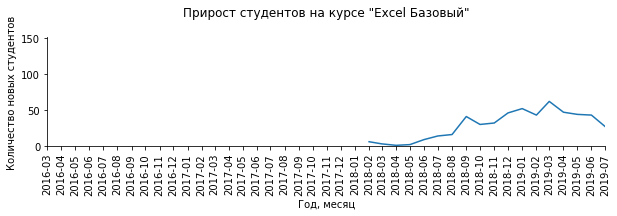

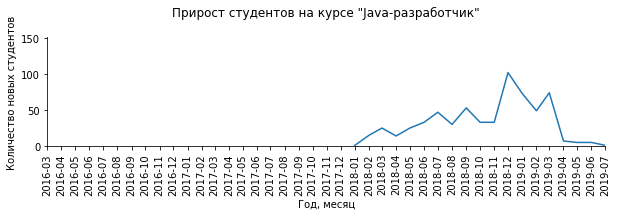

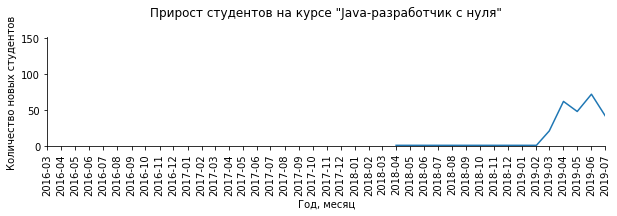

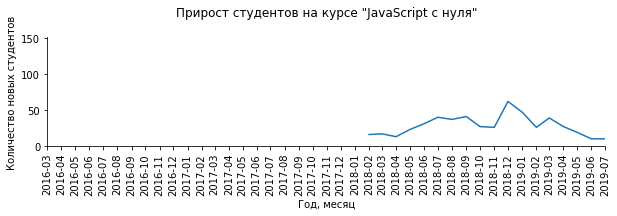

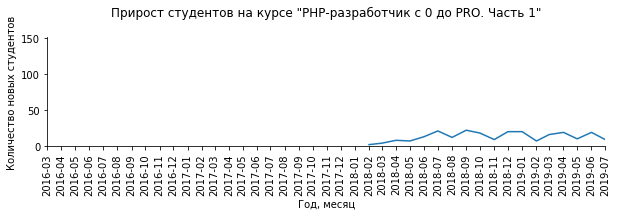

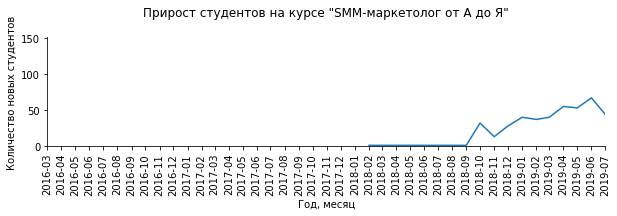

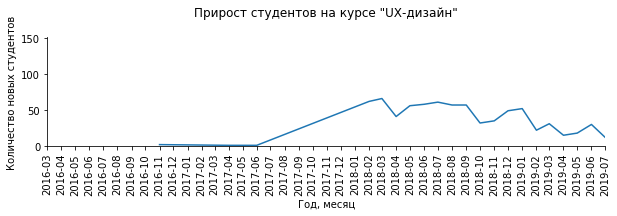

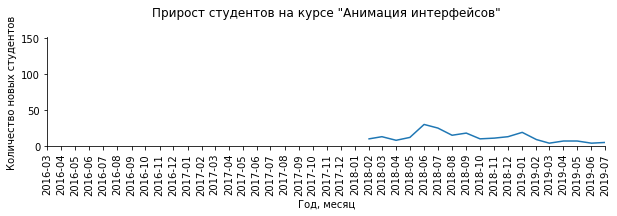

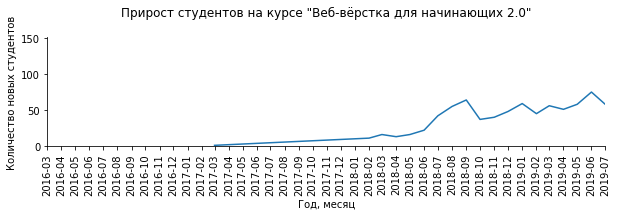

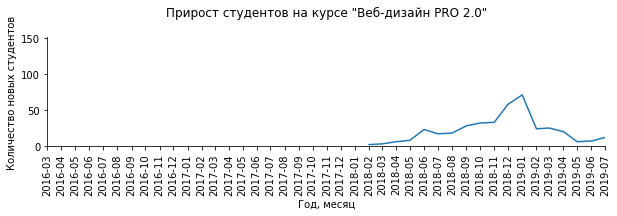

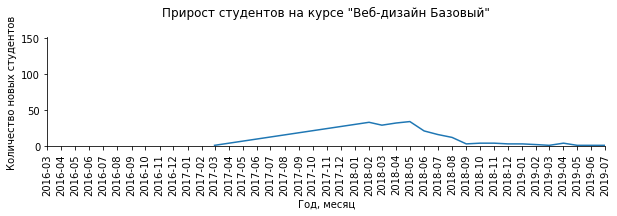

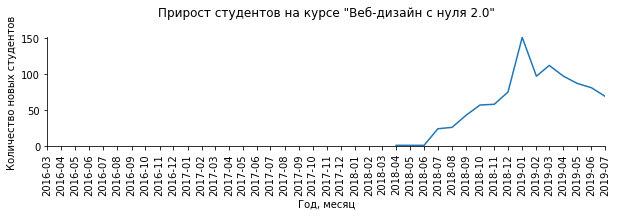

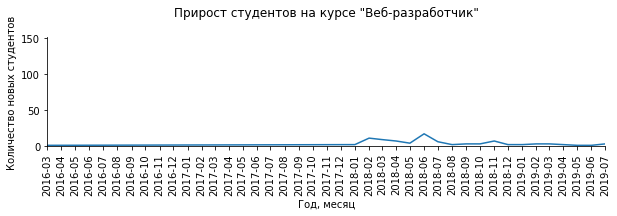

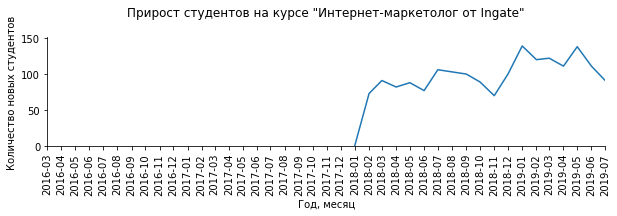

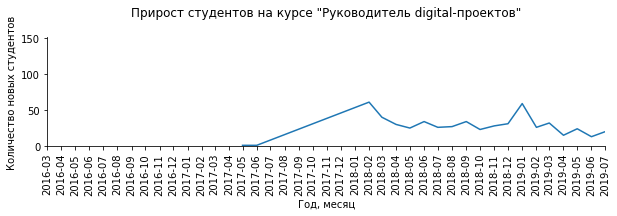

In [14]:
#формирую список курсов для цикла
titles = np.unique(main['title'])

#строим график для каждого курса отдельно
for course in titles:
    fig, subplot = plt.subplots(figsize=(10,2))
    plt.xlabel('Год, месяц')
    plt.ylabel('Количество новых студентов')
    subplot.spines['right'].set_visible(False)
    subplot.spines['top'].set_visible(False)
    subplot.xaxis_date()
    
    data = data = growth[growth['title'] == course]
    x = data.index
    y = data['count_users']

    #установим лимит по оси y, чтобы графики были сопоставимы
    subplot.set_ylim(0,max(growth['count_users']))

    #формируем подписи оси х (редактируем как даты)
    formatter = mdates.DateFormatter("%Y-%m")
    subplot.xaxis.set_major_formatter(formatter)

    #приводим все оси x к одному базису, чтобы графики были сопоставими
    datemin = min(growth.index)
    datemax = max(growth.index) 
    subplot.set_xlim(datemin, datemax)

    months = mdates.MonthLocator()
    subplot.xaxis.set_major_locator(months)
        
    plt.xticks(rotation=90)
    subplot.set_title(f'Прирост студентов на курсе "{course}"\n')
    
    plt.plot(x,y)
#     plt.savefig(f'Количество студентов на курсе {course}.png',bbox_inches='tight')

**Задание 2.3**: На основании первого пункта построить line-graph с несколькими линиями, отражающими прирост студентов в каждом месяце для каждого курса. 15 линий на графике. Ticks нужно развернуть так, чтобы они были читаемы. График должен иметь заголовок. Ось, отражающая прирост, должна быть подписана. Линия для каждого курса должна иметь свой цвет (нужна легенда). Рамок у графика быть не должно ⭐

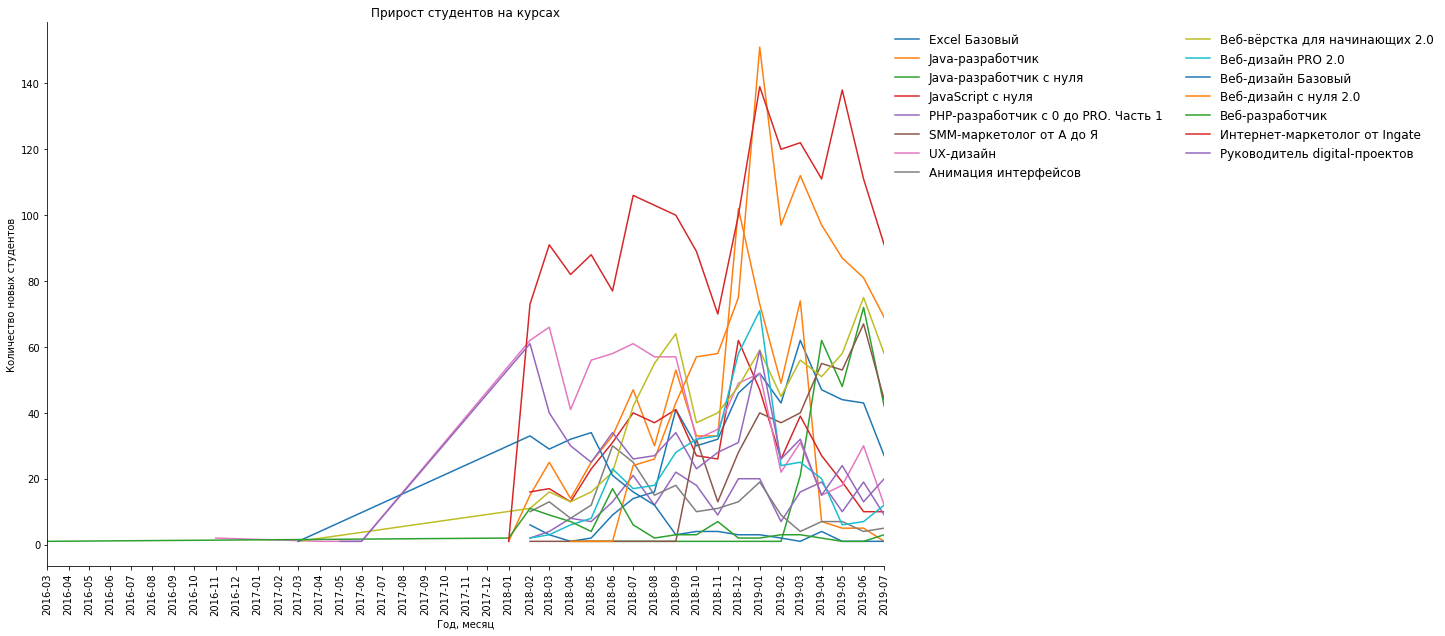

In [15]:
#создаем полотно графика
fig, subplot = plt.subplots(figsize=(15,10))

#устанавливаем названия осей и самого графика
plt.xlabel('Год, месяц')
plt.ylabel('Количество новых студентов')
subplot.set_title('Прирост студентов на курсах')

#удаляем правую и верхнюю границы графика
subplot.spines['right'].set_visible(False)
subplot.spines['top'].set_visible(False)

#строим график(линию) по каждму курсу
for course in np.unique(main['title']):
    data = growth[growth['title'] == course]
    x = data.index
    y = data['count_users']
    
    plt.plot(x,y)

months = mdates.MonthLocator() #устанавливаем разделители оси х
subplot.xaxis.set_major_locator(months) #разделители на оси х = месяцы
datemin = min(growth.index)  #минимальная дата на оси х
datemax = max(growth.index)  #максимальная дата на оси х
subplot.set_xlim(datemin, datemax)
plt.xticks(rotation=90)

#настраиваем легенду графика
plt.legend([i for i in np.unique(main['title'])], frameon = False, ncol = 2, fontsize = 'large', bbox_to_anchor=(1, 1))

plt.savefig('Прирост студентов на курсах.png', bbox_inches='tight')

plt.show()

**Задание 2.4**: Рассчитать количество прогрессов по выполнению домашних работ в каждом месяце за всю историю (каждый месяц в диапазоне от марта 2016 до июля 2019 включительно) для каждого курса. Учитывать, что выполнение домашнего задания может перетекать из одного месяца в другой (такие дз надо включать в общее число прогрессов для всех месяцев, которые покрывает срок выполнения этих дз)

In [16]:
#подготавливаем датасет для расчетов
progress_count = main[main['is_homework'] == True].loc[:, ['title', 'start_date', 'finish_date']]
progress_count.dropna(inplace = True)
# progress_count.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)

#необходимо обновить нумерацию индексов, т.к. при срезе ранее она сбилась и это мешает при применении цикла for ниже
progress_count.reset_index(inplace = True, drop = True) 

#преобразуем строковые значение дат в в формат datetime 
progress_count['start_date'] = progress_count['start_date'].map(lambda x: datetime.strptime(x[:7], '%Y-%m'))
progress_count['finish_date'] = progress_count['finish_date'].map(lambda x: datetime.strptime(x[:7], '%Y-%m'))

#создаем списки, которые будут заполняться ниже для создания конечного датасета
titles=[] #название курса
date_labels=[] #месяц и год

#цикл для заполнения ранее объявленных списков
for row in range(len(progress_count)):
    test_start = progress_count.loc[row,'start_date']
    test_end = progress_count.loc[row,'finish_date']   
    
    #дата начала обучения уже покрывает месяц, поэтому сразу добавлям параметры в списки
    titles.append(progress_count.at[row,'title'])
    date_labels.append(test_start)
            
    # далее проверяем, равна ли дата начала дате окончания прогресса
    # если равна, то ничего не предпринимаем, т.к. ранее уже учли данную дату
    if test_start == test_end:
        continue
        
    else:          
        #если не равна, то вычитаем из даты окончания один месяц до тех пор, пока не дойдем до даты начала.
        #в это же время добавляем в соответствующие списки наименование курса; дату (год и месяц), которую
        #покрывает прогресс
        while test_end > test_start:
            test_end -= dateutil.relativedelta.relativedelta(months=1)
            
            if test_end == test_start:
                continue
            
            titles.append(progress_count.at[row,'title'])
            date_labels.append(test_end)
            
#создаем датафрейм из полученных списков и сортируем данные по дате            
progress_by_month = pd.DataFrame(list(zip(titles, date_labels)), columns = ['title', 'start_date'])
progress_by_month.sort_values(by = 'start_date', inplace = True)

#добавляем столбик для хранения количества прогрессов
progress_by_month['months_homework'] = 1

#применяем агрегирующую функцию sum к полученному датасету. Получаем количество прогрессов на каждом курсе за каждый месяц
progress_by_month = progress_by_month.groupby(['start_date', 'title'], sort = False).agg('sum')

progress_by_month

months_homework
start_date title                                    
2016-03-01 Веб-разработчик                         5
2016-11-01 UX-дизайн                               4
2016-12-01 UX-дизайн                               1
2017-02-01 UX-дизайн                               2
2017-03-01 Веб-дизайн Базовый                      3
...                                              ...
2019-07-01 Веб-дизайн PRO 2.0                     85
           Анимация интерфейсов                    9
           UX-дизайн                              40
           SMM-маркетолог от А до Я               57
           Веб-разработчик                        12

[253 rows x 1 columns]

**Задание 2.5**: Построить line-graph по четвертому пункту. 15 графиков. Графики должны иметь заголовки, оси должны быть подписаны. Ticks нужно развернуть так, чтобы они были читаемы

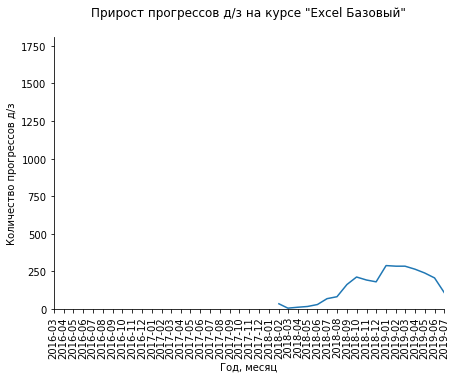

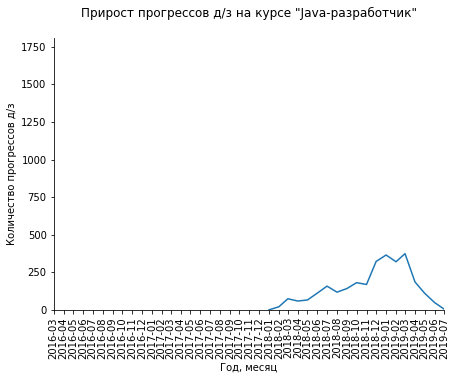

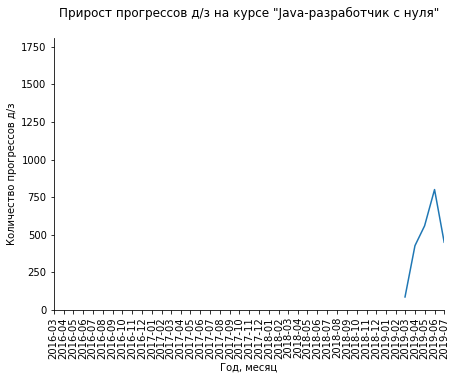

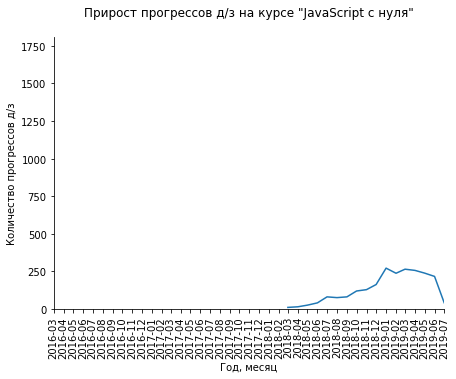

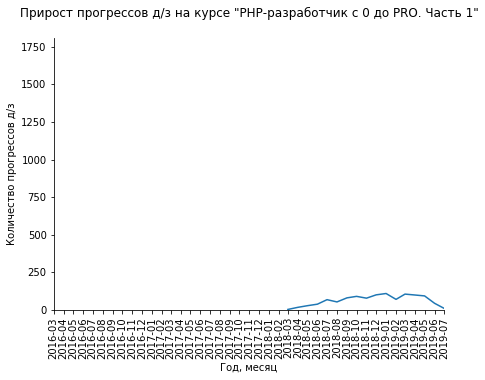

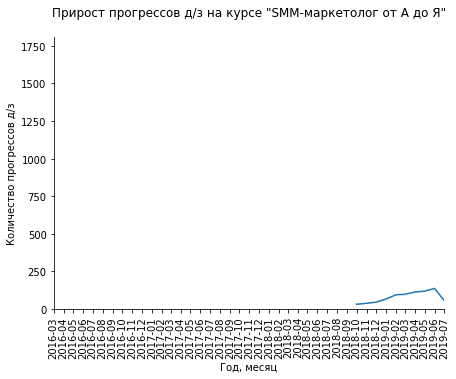

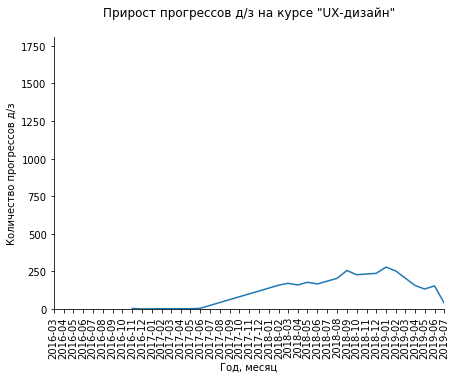

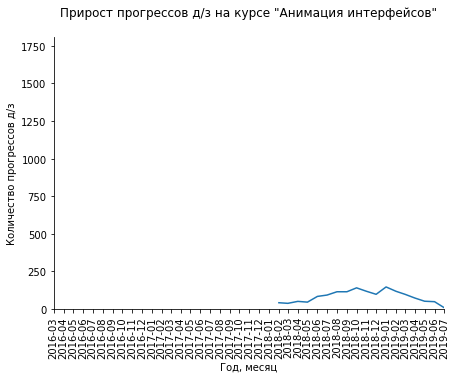

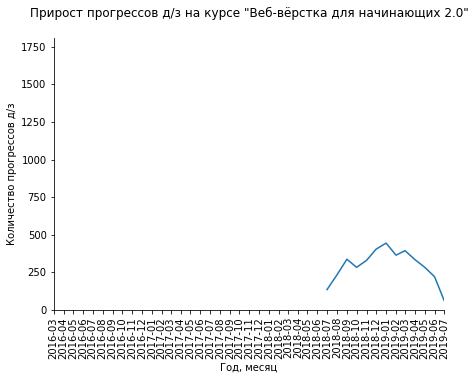

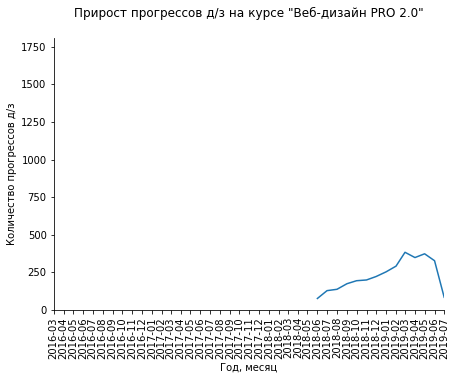

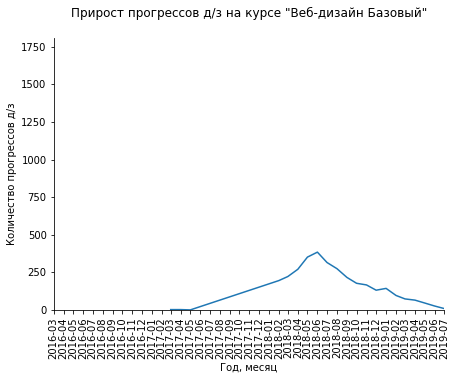

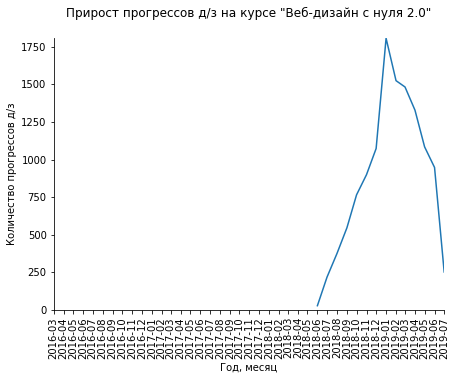

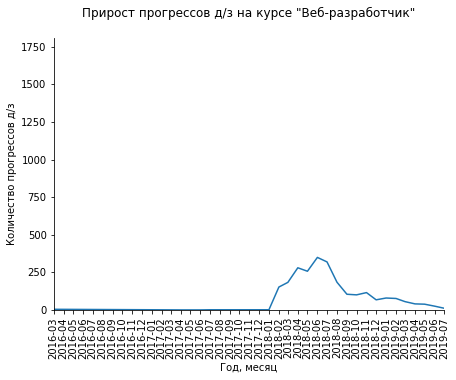

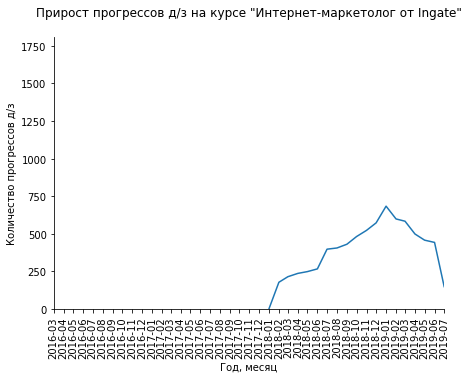

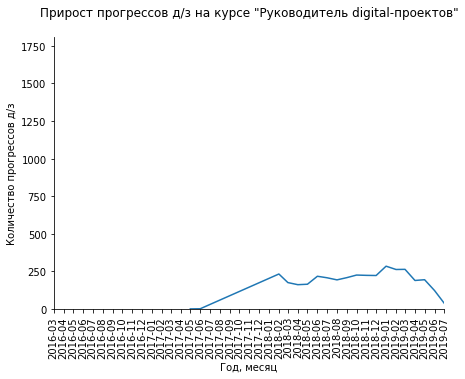

In [17]:
#для удобства копируем датасет из задания 2.4 и сбрасываем индексы
plots_data=progress_by_month.copy().reset_index()

for title in np.unique(main['title']):
    
    #формируем данные для каждого из 15 графиков
    data = plots_data[plots_data['title'] == title]
    
    #при каждой итерации создаем новое полотно
    fig, subplot = plt.subplots(figsize = (7,5))
    
    #устанавливаем наименования осей
    plt.xlabel('Год, месяц')
    plt.ylabel('Количество прогрессов д/з')
    
    #убираем верхнюю и правую границы графика
    subplot.spines['right'].set_visible(False)
    subplot.spines['top'].set_visible(False)
    
    #задаем наименование каждого из 15 графиков
    subplot.set_title(f'Прирост прогрессов д/з на курсе "{title}"\n')
    
    #формируем линию на графике
    plt.plot(data['start_date'], data['months_homework'])
    
    #установим лимит по оси y, чтобы графики были сопоставимы
    subplot.set_ylim(0,max(plots_data['months_homework']))

    #формируем подписи оси х (редактируем как даты)
    formatter = mdates.DateFormatter("%Y-%m")
    subplot.xaxis.set_major_formatter(formatter)

    #приводим все оси x к одному базису, чтобы графики были сопоставими
    datemin = min(plots_data['start_date'])
    datemax = max(plots_data['start_date']) 
    subplot.set_xlim(datemin, datemax)

    months = mdates.MonthLocator()
    subplot.xaxis.set_major_locator(months)
        
    plt.xticks(rotation=90)
    
    #сохраняем график (для аналитики)
#     plt.savefig(f'Прирост прогрессов дз на курсе {title}.png',bbox_inches='tight')

**Задание 2.6**: Построить один line-graph для всех курсов по четвертому пункту. 15 линий на графике. Ticks нужно развернуть так, чтобы они были читаемы. График должен иметь заголовок. Ось, отражающая количество прогрессов, должна быть подписана. Линия для каждого курса должна иметь свой цвет (нужна легенда). Рамок у графика быть не должно

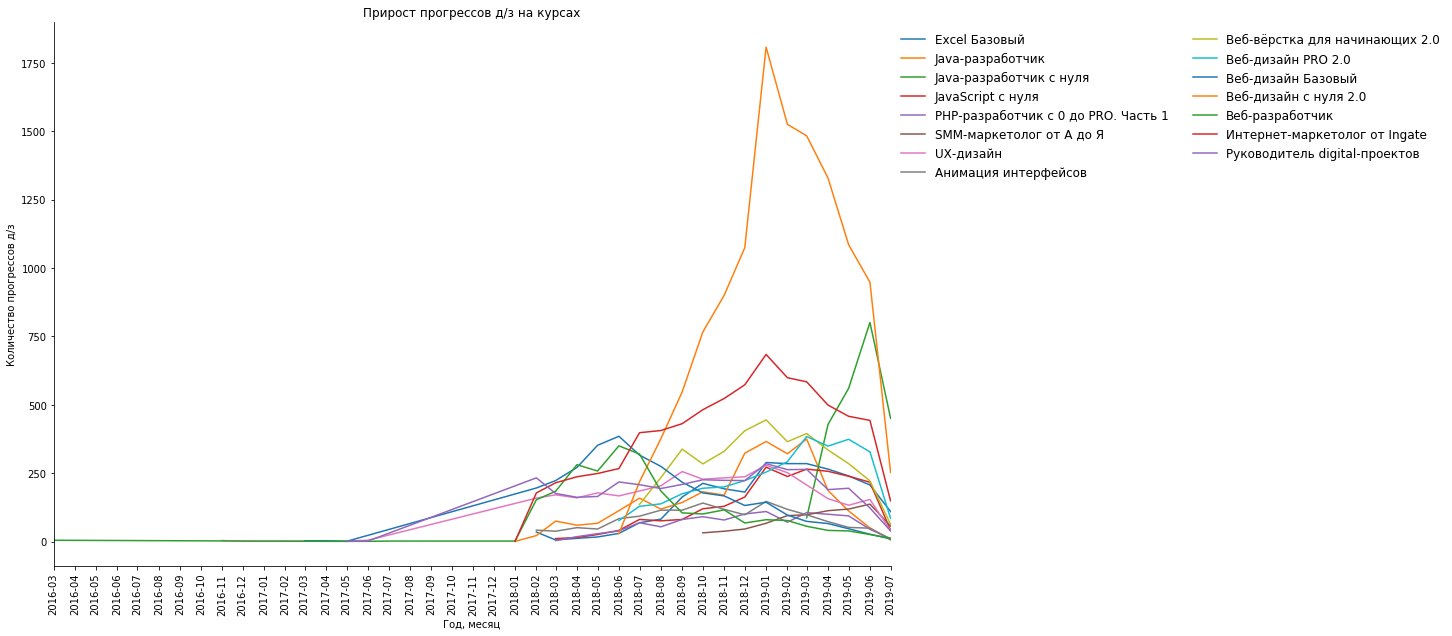

In [18]:
fig, subplot = plt.subplots(figsize=(15,10))
plt.xlabel('Год, месяц')
plt.ylabel('Количество прогрессов д/з')
subplot.spines['right'].set_visible(False)
subplot.spines['top'].set_visible(False)

subplot.set_title('Прирост прогрессов д/з на курсах')


for course in np.unique(main['title']):
    data = plots_data[plots_data['title'] == course]
    x = data['start_date']
    y = data['months_homework']
    
    plt.plot(x,y)

    
#формируем подписи оси х (редактируем как даты)
formatter = mdates.DateFormatter("%Y-%m")
subplot.xaxis.set_major_formatter(formatter)

#приводим все оси x к одному базису, чтобы графики были сопоставими
datemin = min(plots_data['start_date'])
datemax = max(plots_data['start_date']) 
subplot.set_xlim(datemin, datemax)

months = mdates.MonthLocator()
subplot.xaxis.set_major_locator(months)

plt.xticks(rotation=90)

plt.legend([i for i in np.unique(main['title'])], frameon = False, ncol = 2, fontsize = 'large', bbox_to_anchor=(1, 1))
plt.savefig('Прирост прогрессов дз на курсах.png',bbox_inches='tight')

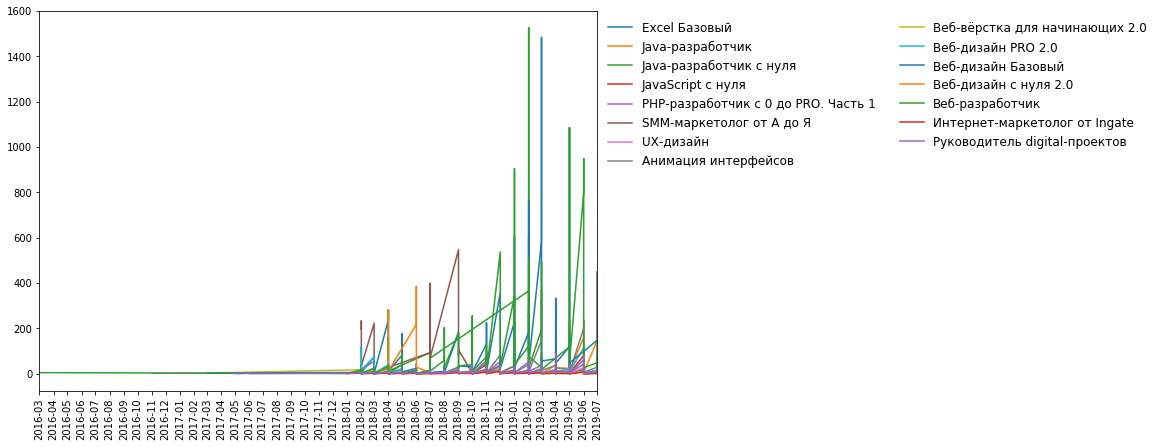

In [19]:
#строю график с соотношением прогрессы/новые ученики помесячно для каждого курса. Это необходимо для того,
#чтобы оценить необходимость в увеличении штата сотрудников

progress_exceeds_students = growth.merge(progress_by_month.reset_index().set_index('start_date'), 
                                         left_index = True, right_index = True).drop('title_y', axis = 1).reset_index()
                                        
progress_exceeds_students['progress_per_new_student'] = progress_exceeds_students['months_homework']/progress_exceeds_students['count_users']

fig, subplot = plt.subplots(figsize=(10,7))

formatter = mdates.DateFormatter("%Y-%m")
subplot.xaxis.set_major_formatter(formatter)

datemin = min(progress_exceeds_students['start_date'])
datemax = max(progress_exceeds_students['start_date']) 
subplot.set_xlim(datemin, datemax)

months = mdates.MonthLocator()
subplot.xaxis.set_major_locator(months)

for course in np.unique(main['title']):
    data = progress_exceeds_students[progress_exceeds_students['title_x'] == course]
    x = data['start_date']
    y = data['progress_per_new_student']
    
    plt.plot(x,y)

plt.xticks(rotation=90)

plt.legend([i for i in np.unique(main['title'])], frameon = False, ncol = 2, fontsize = 'large', bbox_to_anchor=(1, 1))
plt.savefig('Соотношение прогрессов и учеников.png',bbox_inches='tight')
plt.show()


### Аналитический отчет: оценка необходимости увеличения штата сотрудников

На основе исходных данных был построен общий график по приросту студентов на каждом курсе.
Как видно из графика, резкий прирост студентов наблюдался в январе 2019 года по курсу Java-разработчик (более 200 человек).
В целом можно отметить положительную динамику роста количества студентов на каждом курсе на протяжении рассмотренного периода.

<img src='Прирост студентов на курсах.png'>

Далее расмотрим график с приростом прогрессов домашних заданий по всем курсам.

<img src='Прирост прогрессов дз на курсах.png'>

Данный график демонстрирует резкий прирост прогрессов дз в январе 2019 года по курсу Java-разработчик. Это ожидаемо, т.к. в этот период произошел резкий прирост количества студентов на курсе. В целом, насколько видно из графиков, динамика роста прогрессов дз совпадает с динамикой прироста новых студентов.

Для того, чтобы оценить нагрузку преподавателей и необходимость в расширении штата, был построен график с соотношением количества прогрессов.

<img src='Соотношение прогрессов и учеников.png'>

Таким образом, на протяжении всего рассматриваемого периода наблюдается значительное превышение прогрессов дз над приростом студентов на курсах Excel Базовый и Java-разработчик с нуля. Это говорит о том, что, возможно, в будущем появится необходимость в расширении штата сотрудников именно на данных курсах.

## Выявление проблемных модулей

**Задание 3.1**: Рассчитать минимальное, максимальное, среднее, медианное время прохождения каждого модуля  (разность между временем начала и окончания выполнения домашней работы) для каждого курса. Если домашних заданий  в модуле несколько, то считать разность между временем начала выполнения первой домашней работы и временем  окончания выполнения последней домашней работы в модуле

In [20]:
#формируем необходимый датасет, удаляем строки с пустыми ячейками. Строки с пустыми значениями дат удаляю, т.к. они не 
#будут участвовать в расчетах

homework_time = main[main.is_homework == True].loc[:, ['title', 'module_title', 'progress_id',
                                                       'start_date', 'finish_date', 'is_homework']]
homework_time = homework_time[homework_time['is_homework'] == True] .dropna()

#Приводим даты к формату datetime. В связи с тем, что необходимо обрабатывать значения NaN, создадим следующую функцию:
def tryconvert(date):
    try:
        date=datetime.strptime(date[0:10],'%Y-%m-%d').date() 
    except TypeError:
        pass
    return date

homework_time['start_date'] = homework_time['start_date'].map(lambda x: tryconvert(x))
homework_time['finish_date'] = homework_time['finish_date'].map(lambda x: tryconvert(x))

#Учитываем тот факт, что в модуле может быть несколько домашних заданий
#Для этого я написала 2 функции trymin (применяем к start_date) и trymax (применяем к finish_date)

def trymin(dates):
    try:
        return dates.min()
    except:
        pass
    return None

def trymax(dates):
    try:
        return dates.max()
    except:
        pass
    return None

#Применяем созданные функции к датам в датасете
homework_time=homework_time.groupby(['title','module_title','progress_id'], sort=False) \
                           .agg({'start_date':trymin,'finish_date':trymax})

#Убираем ненужные столбцы
homework_time=homework_time.reset_index() \
                           .loc[:, ['title', 'module_title', 'start_date', 'finish_date']]
homework_time_v2=homework_time #для задания 3.3

#рассчитываем длительность выполнения дз в днях
homework_time['complete'] = homework_time.apply(lambda x: round((x[3] - x[2])/timedelta(1)),axis=1)

#применяем агрегирующие функции к столбику 'complete' для расчета необходимых метрик
homework_time = homework_time.groupby(['title', 'module_title']) \
                             .agg(['min', 'max', 'mean','median']) \
                             .astype('int') \
                             .reset_index()

homework_time.head()

title                                    module_title complete  \
                                                                      min   
0  Excel Базовый                       Визуализация данных Excel        0   
1  Excel Базовый                       Основной функционал Excel        0   
2  Excel Базовый         Основной функционал Excel (продолжение)        0   
3  Excel Базовый                           Сводные таблицы Excel        0   
4  Excel Базовый  Формулы и функции Excel. Более сложные формулы        0   

                    
   max mean median  
0  175   10      5  
1  184    6      2  
2  185    4      2  
3  239    9      3  
4  176    7      3

**Задание 3.2**: На основании первого пункта построить line-graph с медианным временем прохождения каждого модуля для каждого курса. 15 графиков. Графики должны иметь заголовки

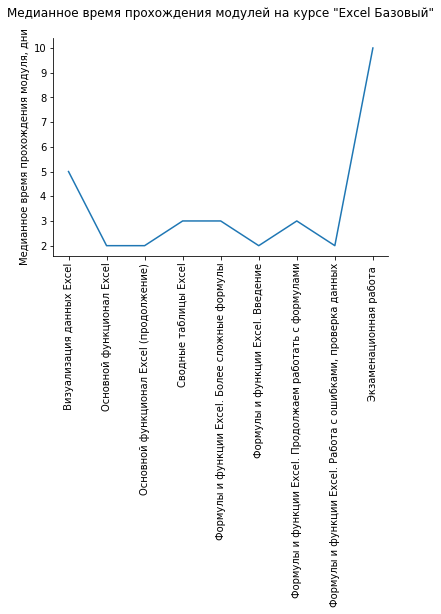

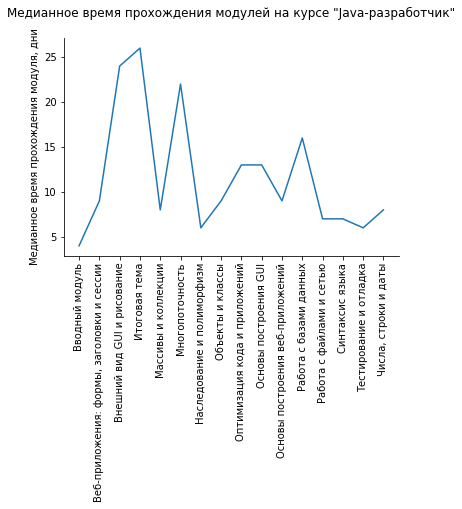

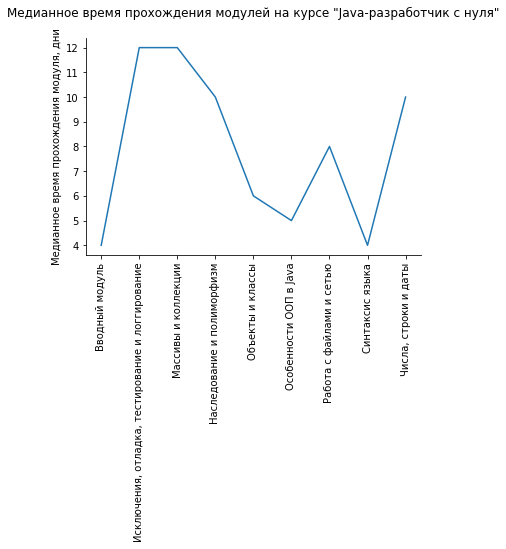

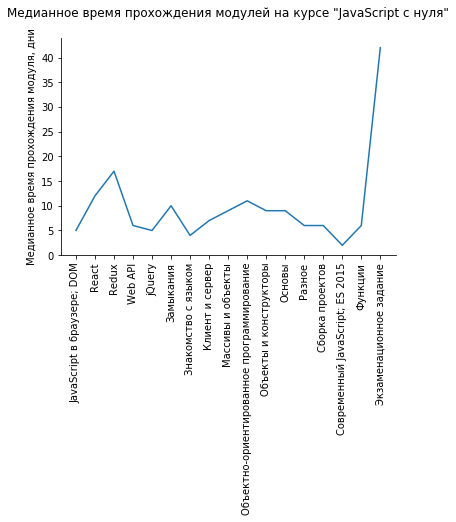

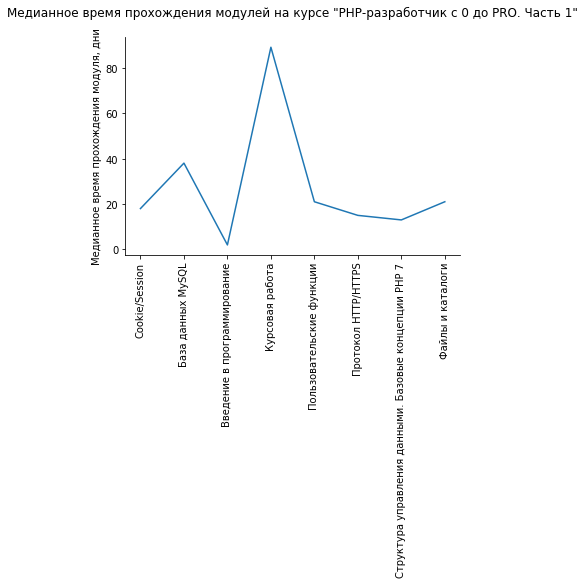

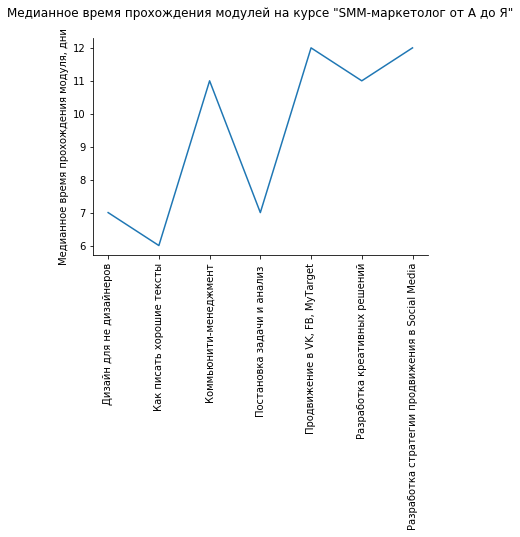

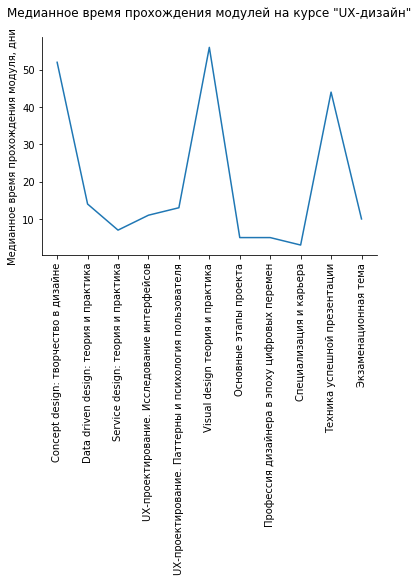

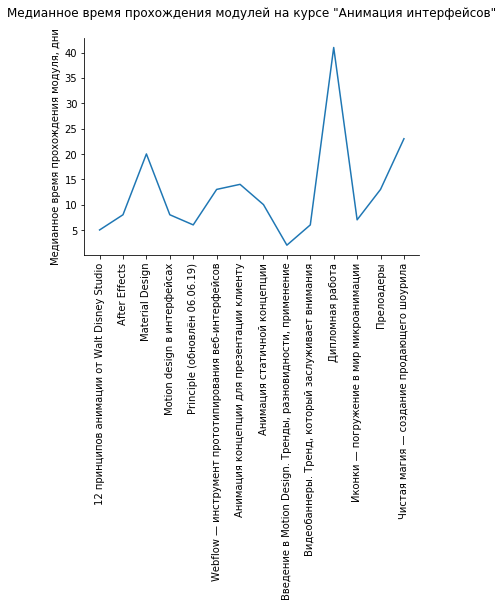

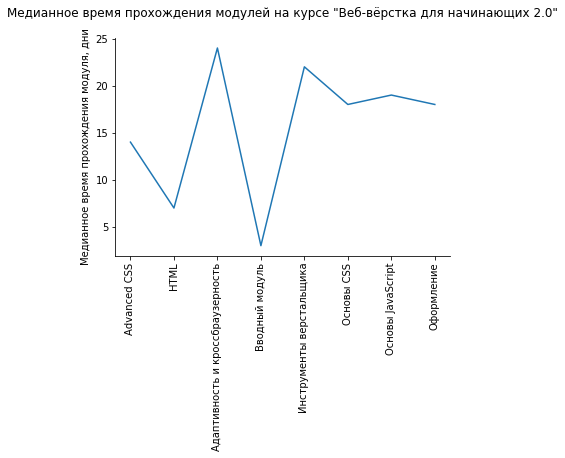

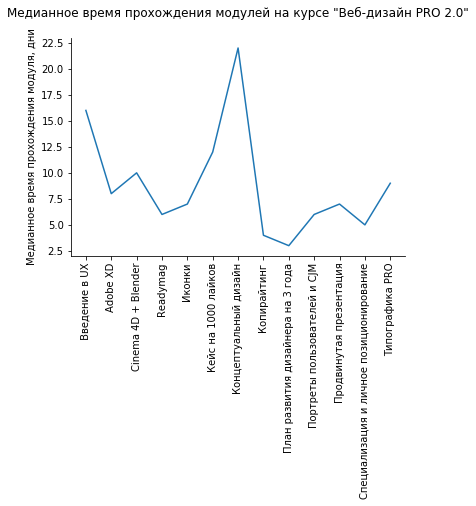

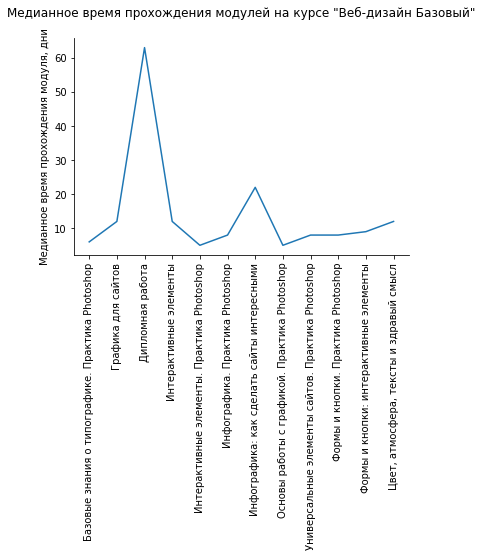

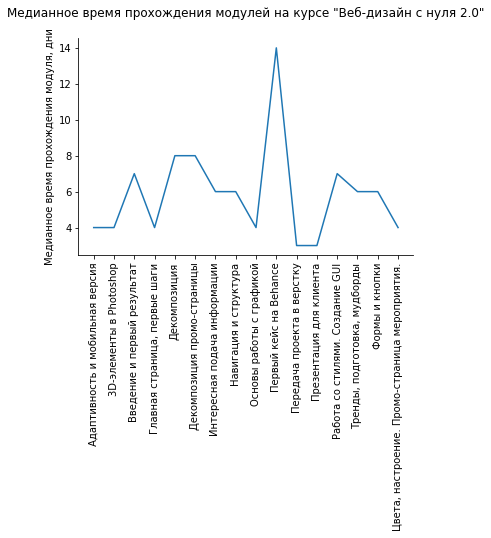

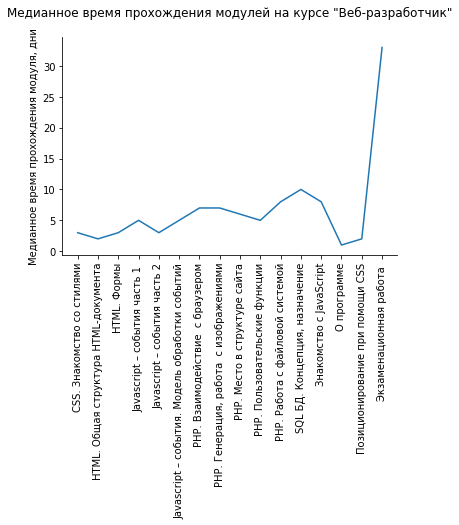

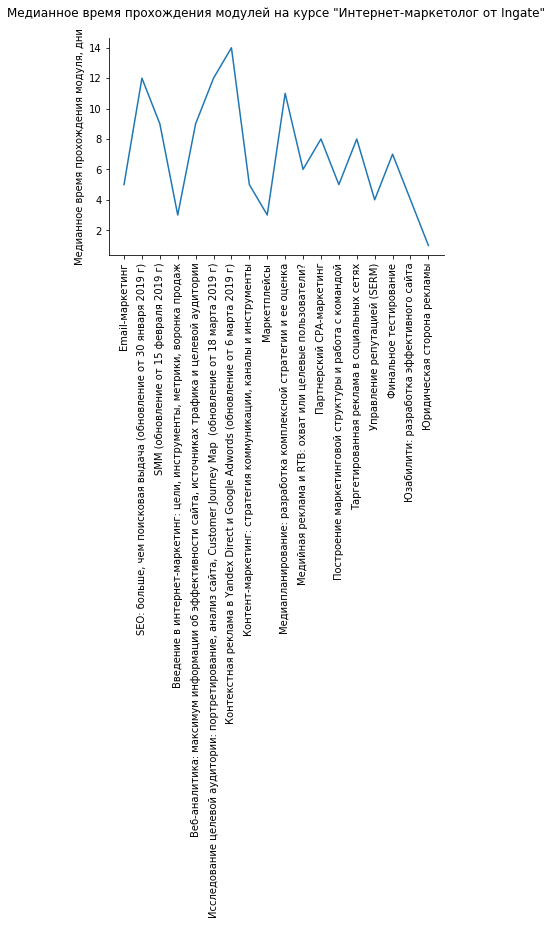

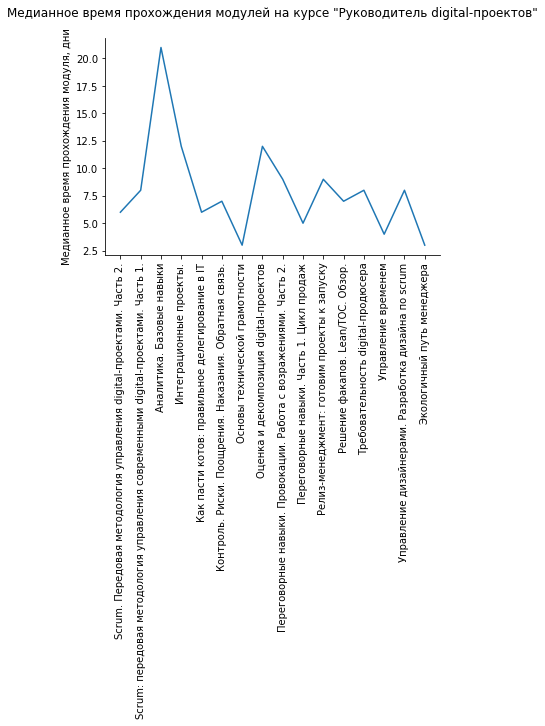

In [21]:
for course in np.unique(main['title']):  #количество графиков = количество курсов
    fig, subplot = plt.subplots()
    plt.ylabel('Медианное время прохождения модуля, дни')
    subplot.spines['right'].set_visible(False)
    subplot.spines['top'].set_visible(False)
     
    data = homework_time[homework_time['title'] == course].iloc[:, [0,1,5]]  #из основного дс выделяем нужные столбцы

    x = data['module_title']
    y = data[('complete', 'median')]
    plt.plot(x,y)
    
    plt.xticks(rotation=90)  #переворачиваем подписи оси х
    
    subplot.set_title(f'Медианное время прохождения модулей на курсе "{course}"\n') #указываю название графика
    plt.savefig(f'Медианное время прохождения модулей на курсе {course}.png',bbox_inches='tight')

**Задание 3.3**: Чтобы выявить сезонность, посчитать медианное время выполнения домашней работы по месяцам  (12 месяцев, январь-декабрь) для каждого курса.

In [22]:
#формируем необходимый дата сет
homework_season = homework_time_v2.loc[:, ['title', 'start_date', 'finish_date']]

#создаем функцию для расчета дней выполнения дз по месяцам по каждому курсу
def count_days(date_start, date_end, course_name):
  
    days=[]
    months=[]
    titles=[]
    
    current_day, current_month, current_year = date_start.day, date_start.month, date_start.year
    end_day, end_month, end_year = date_end.day, date_end.month, date_end.year

    while not(current_month == end_month and current_year == end_year):
        month_length = calendar.monthrange(current_year, current_month)[1] #узнаем количество дней в выбранном месяце
        month_number = current_month 
        days.append(month_length - current_day)
        months.append(month_number)
        titles.append(course_name)
        
       
        if current_month == 12:
            current_month = 1
            current_year += 1
        else:
            current_month += 1
        current_day = 0 # все месяцы кроме первого учитываются полностью, поэтому далее вычитаем 0 из month_length
    else:
        last_month = current_month #отдельно выводим данные по последнему месяцу
        days.append(end_day - current_day)
        months.append(last_month)
        titles.append(course_name)
        
    return days, months, titles

Days=[] #список для хранения количества дней
Months=[] #список для хранения наименования месяцев
Titles=[] #список для хранения наименования курсов

#применяем созданную функцию к нашему датафрему
for i in range(len(homework_season)):
    Day, Month, Title = count_days(homework_season.iloc[i][1], homework_season.iloc[i][2], homework_season.iloc[i][0])
    for i in range (len(Day)): #распаковываем списки из функции, т.к. одно дз могло быть выполнено за несколько месяцев
        Days.append(Day[i])
        Months.append(Month[i])
        Titles.append(Title[i])

        
#создаем датафрейм для сохранения результата
seasonal = pd.DataFrame()
seasonal['Course title']=Titles
seasonal['Month']=Months
seasonal['Median days']=Days

#сортируем данные и номера месяцев заменяем на их названия
seasonal.sort_values(['Course title', 'Month'], inplace=True)
seasonal['Month'] = seasonal['Month'].map(lambda x: calendar.month_name[x])
seasonal=seasonal.groupby(['Course title','Month'], sort=False).agg('median')

#форматируем таблицу для удобства
seasonal=seasonal.unstack(1).fillna(0)

seasonal

Median days                             \
Month                                   January February March April   May   
Course title                                                                 
Excel Базовый                               3.0      2.0   3.0   3.0   3.0   
Java-разработчик                            6.0      5.0   6.0   9.0  11.0   
Java-разработчик c нуля                     0.0      0.0   4.0   5.0   7.0   
JavaScript с нуля                           7.0      6.0   6.0   6.0   5.0   
PHP-разработчик с 0 до PRO. Часть 1        11.0     18.0  14.0   9.0   7.5   
SMM-маркетолог от А до Я                   13.0      8.0   9.0   6.0   8.0   
UX-дизайн                                  13.5      7.0  10.5  10.0   9.0   
Анимация интерфейсов                        8.0      5.0   9.0   9.0   7.5   
Веб-вёрстка для начинающих 2.0             10.0     10.5   9.0  10.0   8.0   
Веб-дизайн PRO 2.0                         10.0      9.0   8.0   8.0   7.0   
Веб-дизайн Базовый                         18.0      4.0  11.0   7.0   6.0   
Веб-дизайн с нуля 2.0                       5.0      6.0   5.0   5.0   4.0   
Веб-разработчик                            12.0      3.0  12.0   4.0   4.0   
Интернет-маркетолог от Ingate               7.0      5.0   6.0   7.0   8.0   
Руководитель digital-проектов               8.0      3.0   7.0   7.0   8.0   

                                                                         \
Month                                June July August September October   
Course title                                                              
Excel Базовый                         2.0  2.0    3.0       2.0     3.0   
Java-разработчик                     11.0  6.0   10.0      10.0     8.0   
Java-разработчик c нуля               6.0  4.0    0.0       0.0     0.0   
JavaScript с нуля                     5.0  5.0    7.0       9.0     9.0   
PHP-разработчик с 0 до PRO. Часть 1   9.0  6.0   11.0       8.0     8.5   
SMM-маркетолог от А до Я              6.0  6.0    0.0       0.0     7.5   
UX-дизайн                             8.0  8.0   11.0      11.0    13.0   
Анимация интерфейсов                  5.0  6.0    5.0       9.0     7.0   
Веб-вёрстка для начинающих 2.0        7.0  3.0    5.0       7.0     9.0   
Веб-дизайн PRO 2.0                    5.0  7.0   18.0      17.0    14.0   
Веб-дизайн Базовый                    6.0  7.0   11.0      11.0    15.5   
Веб-дизайн с нуля 2.0                 4.0  4.0    5.0       7.0     6.0   
Веб-разработчик                       2.0  3.0    5.0       9.0    10.0   
Интернет-маркетолог от Ingate         6.0  5.0    8.0       7.0     8.0   
Руководитель digital-проектов         7.0  6.0   13.0      12.0     6.0   

                                                       
Month                               November December  
Course title                                           
Excel Базовый                            2.0      4.0  
Java-разработчик                         8.0      4.0  
Java-разработчик c нуля                  0.0      0.0  
JavaScript с нуля                        9.0      7.0  
PHP-разработчик с 0 до PRO. Часть 1     21.0     12.0  
SMM-маркетолог от А до Я                11.0     13.0  
UX-дизайн                               13.0     17.0  
Анимация интерфейсов                     9.0     14.0  
Веб-вёрстка для начинающих 2.0           9.0      9.0  
Веб-дизайн PRO 2.0                      10.0     11.0  
Веб-дизайн Базовый                      16.0     17.0  
Веб-дизайн с нуля 2.0                    6.0      7.0  
Веб-разработчик                          8.5     15.0  
Интернет-маркетолог от Ingate            8.0      6.0  
Руководитель digital-проектов            8.0     10.0

**Задание 3.4** На основании третьего пункта построить line-graph, на который будут нанесены линии для каждого курса с медианным временем выполнения домашней работы по месяцам. 15 линий на графике. График должен иметь заголовок. 
Ось, отражающая время прохождения, должна быть подписана. Линия для каждого курса должна иметь свой цвет (нужна легенда). Рамок у графика быть не должно ⭐

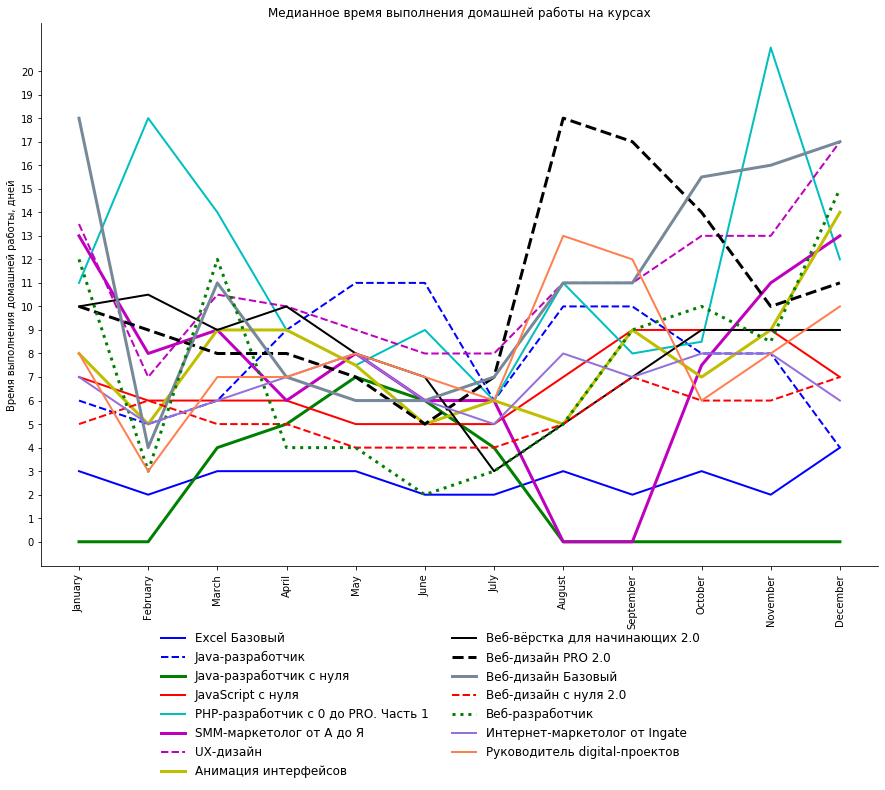

In [23]:

import random

x = [] #переменная для хранения координаты по оси абсцисс
y = [] #переменная для хранения координаты по оси ординат

line_types=['b', '--b', 'g', 'r', 'c', 'm', '--m', 'y', 'k', '--k', 'lightslategray', '--r', ':g', 'mediumpurple', 'coral']

fig, subplot = plt.subplots(figsize=(15,10))
plt.ylabel('Время выполнения домашней работы, дней')
subplot.spines['right'].set_visible(False)
subplot.spines['top'].set_visible(False)
subplot.set_title("Медианное время выполнения домашней работы на курсах")

#формируем список подписей оси х и устанавливаем эти подписи
x_labels=[i[1] for i in seasonal.columns]
plt.xticks(np.arange(len(seasonal.columns)), rotation='vertical', labels=x_labels)

#формируем список подписей оси y и устанавливаем эти подписи
y_max=seasonal.describe().max().max()
plt.yticks(np.arange(y_max))

for course in range (len(seasonal)):
    for month in range (len(seasonal.columns)):
            y.append(seasonal.iloc[course,month])
            x.append(month)
    plt.plot(x,y, line_types[course], linewidth=random.randint(2, 3))

    x = []
    y = []

plt.legend([i for i in list(seasonal.index)], frameon = False, ncol = 2, fontsize = 'large', bbox_to_anchor=(0.8, -0.1))
plt.savefig('Медианное время выполнения дз помесячно.png', bbox_inches='tight')

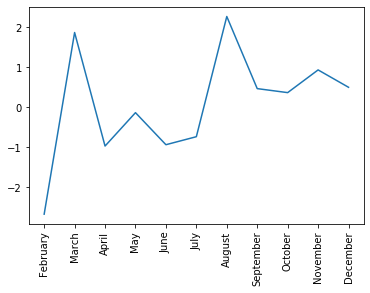

In [37]:
# для оценки сезонности построила график со средним приростом времени выполнения дз помесячно

months = [i[1] for i in seasonal.columns]

plt.plot(months,seasonal.mean().diff())

plt.xticks(rotation = 90)
plt.savefig('Сезонность.png', bbox_inches='tight')

### Аналитический отчет: выявление проблемных модулей и потенциальной сезонности

Среди курсов можно выделить следующие курсы с потенциально проблемными модулями, которые, возможно, необходимо доработать:   
-**`Java-разработчик`**. 

<img src='Медианное время прохождения модулей на курсе Java-разработчик.png'>

Проблемный модуль – Многопоточность. Учитывая специфику и сложность языка, можно предположить, что медианное время прохождения в более чем 20 дней достаточно оправдано. Тем не менее, проблема с прохождением данного модуля явно видна и связана не только со сложностью темы, но и, вероятно, с количеством. Количество уроков на данном модуле равно 7 (максимальное количество уроков на курсе – 9).

-**`PHP-разработчик с 0 до PRO. Часть 1`**.  
<img src='Медианное время прохождения модулей на курсе PHP-разработчик с 0 до PRO. Часть 1.png'>
Проблемные модули - База данных MySQL и Курсовая работа. Модуль "База данных MySQL" состоит из 13 уроков. Учитывая невысокую сложность данной темы, можно предположить, что 50% студентов затрачивает на его прохождение более 20 дней в связи с объемом информации на каждом из 13 уроков. Более того, половина студентов затрачивает около 3х месяцев на выполнение курсовой работы. Это достаточно много, поэтому, возможно, есть смысл упростить либо сократить в объеме курсовую работу.

-**`UX-дизайн`**.  
<img src='Медианное время прохождения модулей на курсе UX-дизайн.png'>
Проблемные модули: Concept design: Творчество в дизайне (медианное время прохождения более 50 дней и состоит из 8 уроков);
Visual design: Теория и практика (медианное время прохождения более 50 дней и состоит из 5 уроков);
Техника успешной презентации (медианное время прохождения более 40 дней и состоит из 4 уроков). Представленные модули не очень велики по объему. Вероятнее всего, подача материала не устраивает студентов, т.к. курс довольно творческий, а творческих людей непросто заинтересовать, поэтому, вероятно, стоит доработать подачу и наполнение данных модулей.


-**`Веб-дизайн PRO 2.0`**.  
<img src='Медианное время прохождения модулей на курсе Веб-дизайн PRO 2.0.png'>
Проблемный модуль: концептуальный дизайн. Он состоит из 5 уроков (максимум по курсу - 6 уроков). Опять же, модуль достаточно творческий, т.к. направлен на разработку идеи проекта.

-**`Веб-дизайн базовый`**. 
<img src='Медианное время прохождения модулей на курсе Веб-дизайн Базовый.png'>
Модуль "Дипломный проект" не считаем проблемным, т.к., как правило, проекты состоят из достаточно большого объема заданий и медианное прохождение модуля в 60 дней считаем приемлемым. Проблемный модуль – Инфографика как сделать сайты интересными. Модуль состоит всего лишь из 2 уроков, но студенты затрачивают на его прохождение 20 дней, что говорит о том, что следует доработать данный модуль.

-**`Веб-дизайн с нуля 2.0`**. 
<img src='Медианное время прохождения модулей на курсе Веб-дизайн с нуля 2.0.png'>
Проблемный модуль – Первый кейс на Behance. Данный модуль явно выделяется по медианному времени прохождения среди других модулей (более 12 дней) и состоит из 4 уроков. Вероятнее всего, следует доработать данный модуль (упростить домашнее задания либо добавить больше уроков по трудным вопросам).

-**`Руководитель digital-проектов`**. 
<img src='Медианное время прохождения модулей на курсе Руководитель digital-проектов.png'>
Проблемный модуль – Аналитика. Базовые навыки. Количество уроков в модуле: 3 (максимум - 12 уроков). Таким образом, долгое время прохождения модуля (более 20 дней), вероятнее всего связано со сложностью материала либо с проблемами в его подаче, а не от большого количества уроков, что в итоге приводит к возникновению трудностей при выполнении домашнего задания.

На медианное время выполнения домашней работы влияет период времени, в который она выполняется (каникулы, новогодние праздники, летний сезон и т.д.). Для того, чтобы понять, когда студенты замедляются при выполнении дз, был построн следующий график, описывающий средний прирост медианного времени прохождения курсов помесячно для всех курсов в целом.

<img src='Сезонность.png'>

Насколько видно из графика, в зимние месяцы медианное время выполнения дз сокращается. Это неудивительно, т.к. в холодные время студенты прогулкам предпочитают теплое помещение и прохождение курсов. И, наоборот, в марте, мае и в августе медианное время прохождения курсов увеличивается. В марте начинаются теплые времена после морозной зимы, а в мае студенты готовятся к летнему отпуску либо к сдаче сессии в университете. В августе же студенты наслаждаются последними днями лета и готовятся к новому учебному году, поэтому проводят меньше времени за прохождением онлайн-курсов


## Расчет конверсии

**Задание 4.1** Посчитать конверсию перехода студентов из одного модуля в другой на каждом курсе. Формула: отношение количества студентов, приступивших к выполнению домашнего задания в этом модуле (если дз в модуле несколько, то считать по первому дз в модуле), к количеству студентов, сдавших задание в предыдущем модуле (если дз в модуле несколько, то считать по последнему дз в модуле).

In [58]:
#Задаем переменной значение общего количества курсов (применяем ниже в цикле)
total_courses = len(set(main['title']))

#Формируем начальный датасет
conversion = main[main.is_homework == True].loc[:, ['title', 'progress_id', 'module_title', 'module_number', 'start_date', 'finish_date']]

#Приводим даты к формату datetime. В связи с тем, что необходимо обрабатывать значения NaN, создадим следующую функцию:
def tryconvert(date):
    try:
        date=datetime.strptime(date[0:10],'%Y-%m-%d').date() 
    except TypeError:
        pass
    return date

conversion['start_date'] = conversion['start_date'].map(lambda x: tryconvert(x))
conversion['finish_date'] = conversion['finish_date'].map(lambda x: tryconvert(x))

#Сортируем датасет по номеру модуля
conversion = conversion.sort_values(['title', 'module_number'])

#Учитываем тот факт, что в модуле может быть несколько домашних заданий
#Для этого я написала 2 функции trymin (применяем к start_date) и trymax (применяем к finish_date) совместно с groupby()

def trymin(dates):
    try:
        return dates.min()
    except:
        pass
    return None

def trymax(dates):
    try:
        return dates.max()
    except:
        pass
    return None

#Применяем созданные функции к датам в датасете
conversion=conversion.groupby(['title','module_title', 'module_number','progress_id'], sort=False).agg({'start_date':trymin,'finish_date':trymax})

#Убираем ненужные столбцы. Module_number оставила, чтобы следить за тем, что сортировка не сбилась.
conversion.reset_index(inplace=True)
conversion=conversion.loc[:, ['title', 'module_title', 'module_number', 'start_date', 'finish_date']]

#Формируем финальный датасет для расчета конверсии
conversion=conversion.groupby(['title','module_title', 'module_number'], sort=False).agg('count')

#Создаем столбик для значений конверсии
conversion['сonversion, %']=0

#Рассчитываем конверсию
for course in range(total_courses):
    for module in range(len(conversion)):     
        if module==0 or conversion.index[module][0]!=conversion.index[module-1][0]:
            conversion.iloc[module,2]=100
        else:
            try:
                conversion.iloc[module,2]=int(conversion.iloc[module][0]/conversion.iloc[module-1][1]*100)
            except:
                conversion.iloc[module,2]=100  

conversion


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in longlong_scalars


start_date  \
title                         module_title                                       module_number               
Excel Базовый                 Основной функционал Excel                          1                     518   
                              Основной функционал Excel (продолжение)            2                     434   
                              Формулы и функции Excel. Введение                  3                     398   
                              Формулы и функции Excel. Продолжаем работать с ... 4                     345   
                              Формулы и функции Excel. Более сложные формулы     5                     298   
...                                                                                                    ...   
Руководитель digital-проектов Решение факапов. Lean/TOC. Обзор.                  12                     95   
                              Интеграционные проекты.                            13                     87   
                              Управление дизайнерами. Разработка дизайна по s... 14                     71   
                              Основы технической грамотности                     15                     66   
                              Контроль. Риски. Поощрения. Наказания. Обратная... 16                     64   

                                                                                                finish_date  \
title                         module_title                                       module_number                
Excel Базовый                 Основной функционал Excel                          1                      458   
                              Основной функционал Excel (продолжение)            2                      406   
                              Формулы и функции Excel. Введение                  3                      387   
                              Формулы и функции Excel. Продолжаем работать с ... 4                      303   
                              Формулы и функции Excel. Более сложные формулы     5                      270   
...                                                                                                     ...   
Руководитель digital-проектов Решение факапов. Lean/TOC. Обзор.                  12                      88   
                              Интеграционные проекты.                            13                      69   
                              Управление дизайнерами. Разработка дизайна по s... 14                      64   
                              Основы технической грамотности                     15                      64   
                              Контроль. Риски. Поощрения. Наказания. Обратная... 16                      58   

                                                                                                сonversion, %  
title                         module_title                                       module_number                 
Excel Базовый                 Основной функционал Excel                          1                        100  
                              Основной функционал Excel (продолжение)            2                         94  
                              Формулы и функции Excel. Введение                  3                         98  
                              Формулы и функции Excel. Продолжаем работать с ... 4                         89  
                              Формулы и функции Excel. Более сложные формулы     5                         98  
...                                                                                                       ...  
Руководитель digital-проектов Решение факапов. Lean/TOC. Обзор.                  12                        96  
                              Интеграционные проекты.                            13                        98  
                              Управление дизайнерами. Разработка дизайна по s... 14                  

**Задание 4.2**. Постройте bar-chart, отражающий конверсию перехода студентов из одного модуля в другой на каждом курсе. 
График должен иметь заголовок. Ticks нужно развернуть так, чтобы они были читаемы

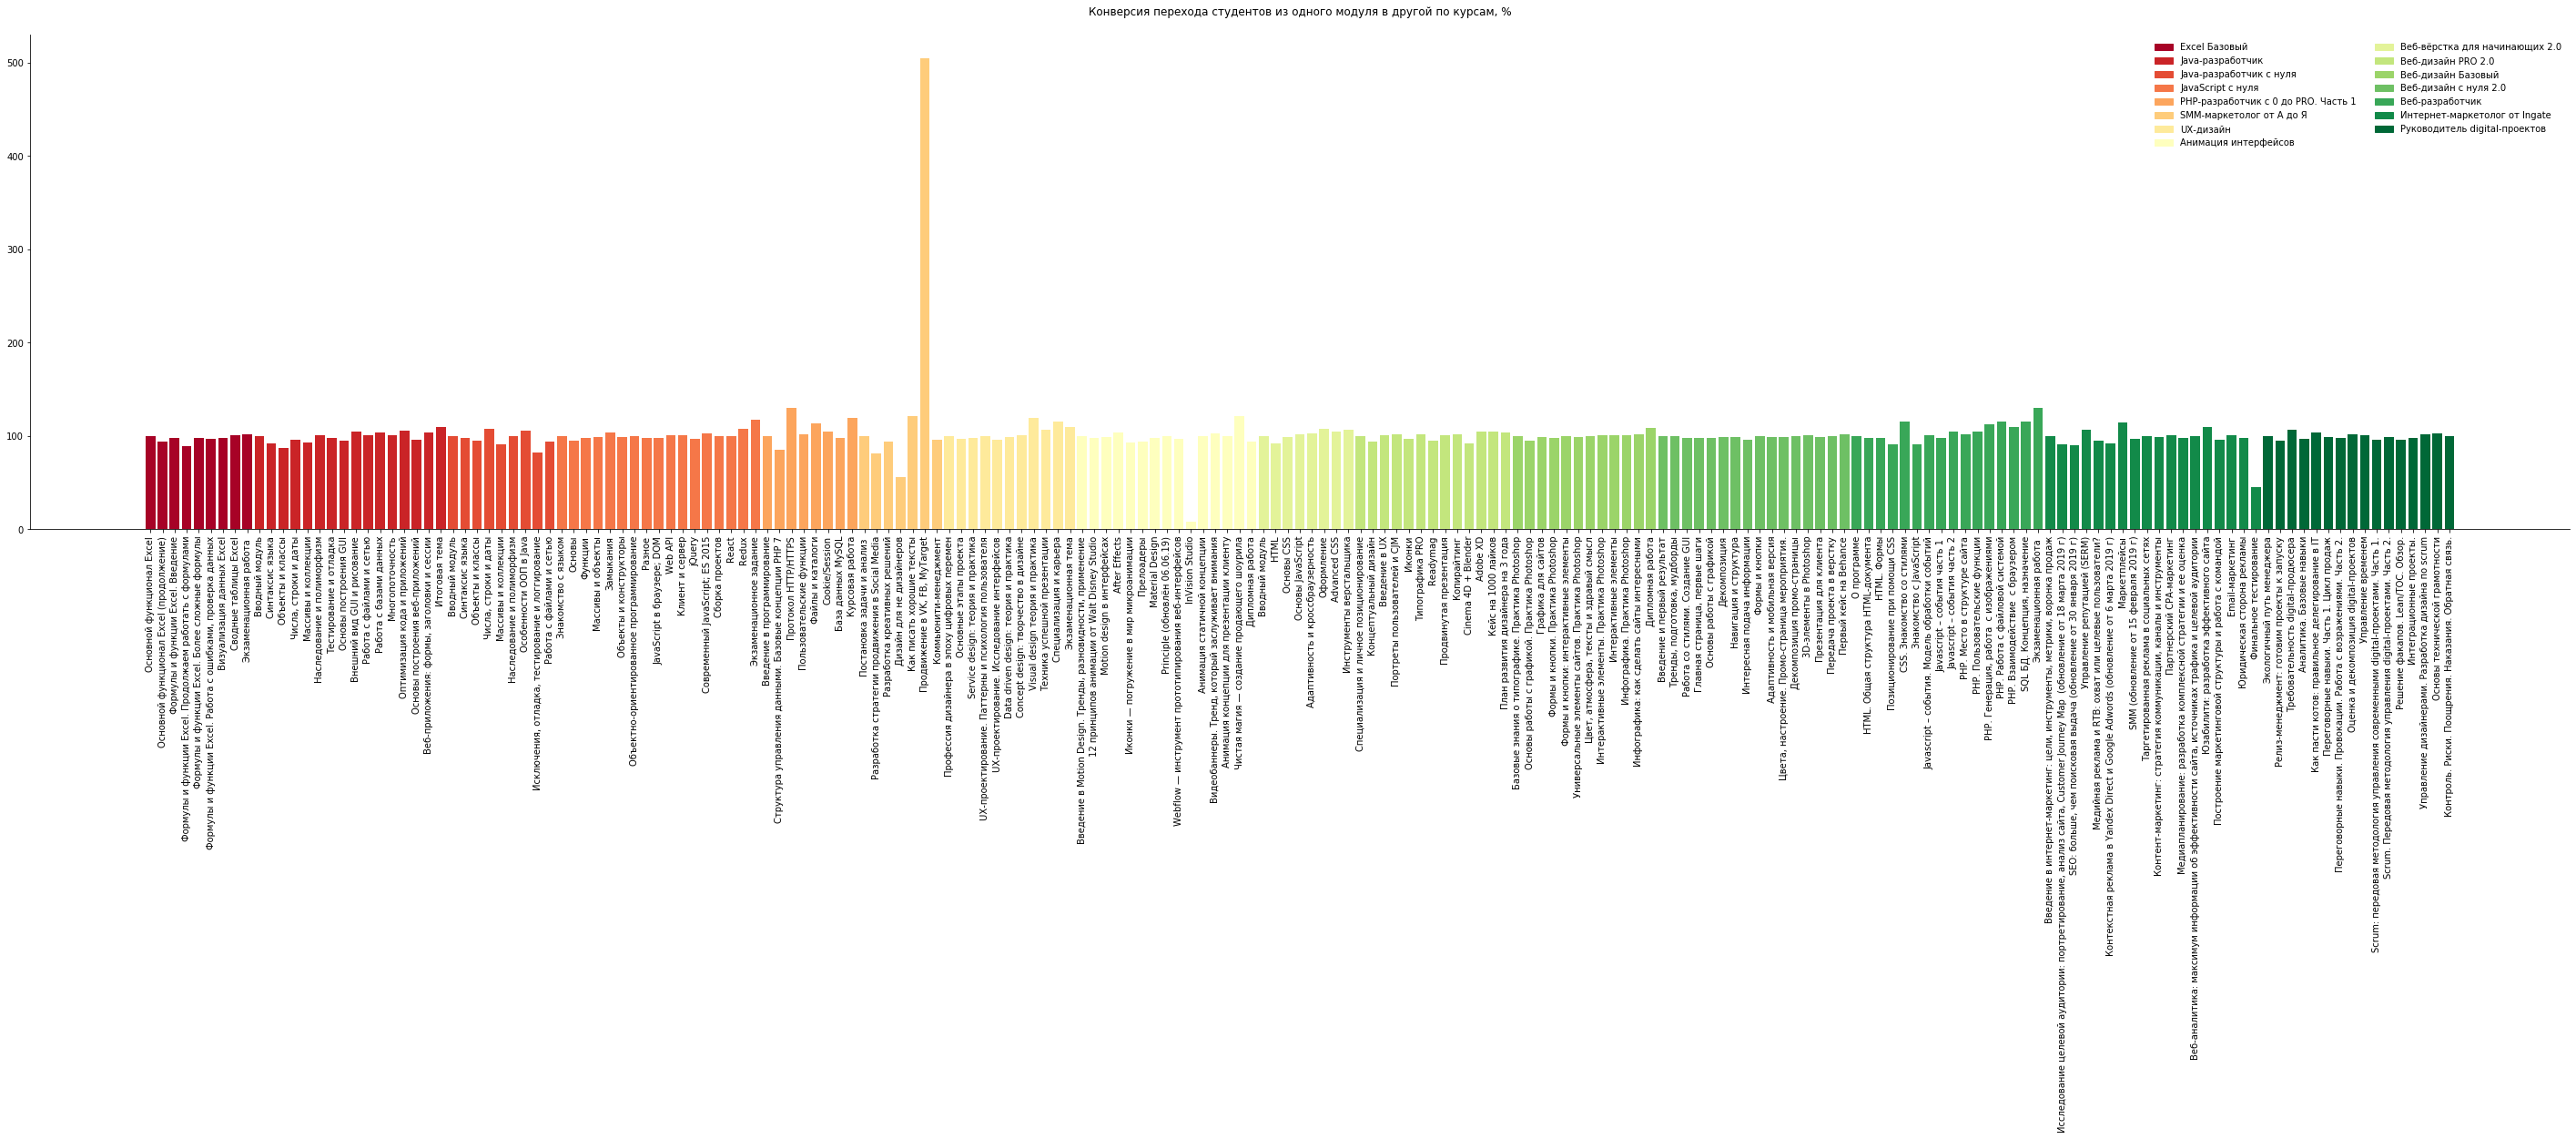

In [55]:
#строим график 

fig, subplot = plt.subplots(figsize = (50,10))
plt.xticks(np.arange(len(x.index)), rotation='vertical', labels=[i[1] for i in x.index])
plt.bar(np.arange(len(x.index)), conversion['сonversion, %'], color = c)

#убираем правую и верхнюю границы графика
subplot.spines['right'].set_visible(False)
subplot.spines['top'].set_visible(False)

#формируем данные для легенды: категории курсов и цвета для каждой категории
titles = np.unique(main['title'])
colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.005, 0.999, len(titles)))

#создаем словарь, где key = наименование категории курса, value - цвет
category = dict(zip(titles, colors))

#создаем массив, который хранит цвета в зависимости от категории для каждого курса
c = conversion.reset_index()['title'].apply(lambda x: category[x])

#формируем подписи для легенды и саму легенду
legend_labels = list(category.keys())
handles = [plt.Rectangle((0,0),1,1, color=category[label]) for label in legend_labels]
plt.legend(handles, legend_labels, frameon = False, ncol = 2)

#название графика
subplot.set_title('Конверсия перехода студентов из одного модуля в другой по курсам, %\n')

plt.show()

**Задание 4.3**: Постройте горизонтальный (столбцы должны располагаться горизонтально) bar-chart, отражающий конверсию перехода студентов из одного модуля в другой на каждом курсе. 15 графиков. Графики должны иметь заголовки. Ticks должны содержать номер и название модуля. Цвет столбцов графиков должен содержать информацию о сфере, к которой относится курс (нужна легенда). Прозрачность должна стоять на отметке 0.1. На графики должна быть нанесена линия медианы конверсии для каждого курса. У медианы должен быть свой цвет. Рамок у графиков быть не должно ⭐

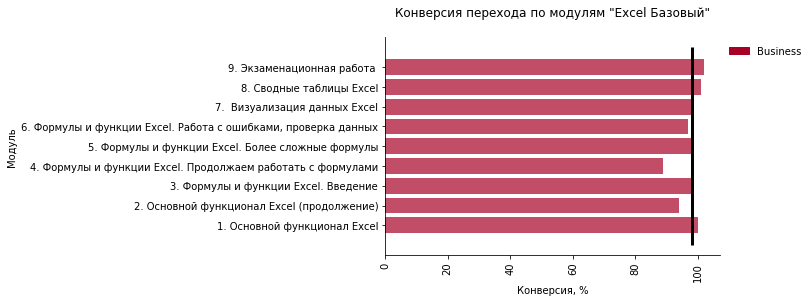

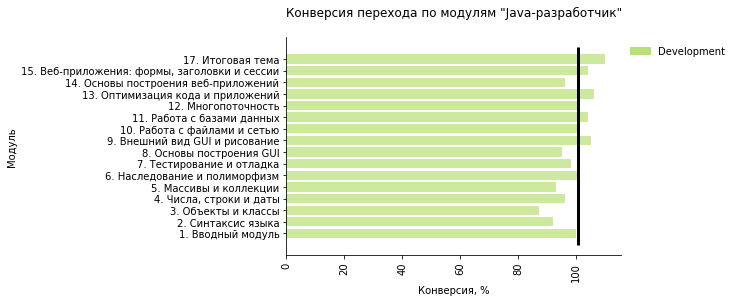

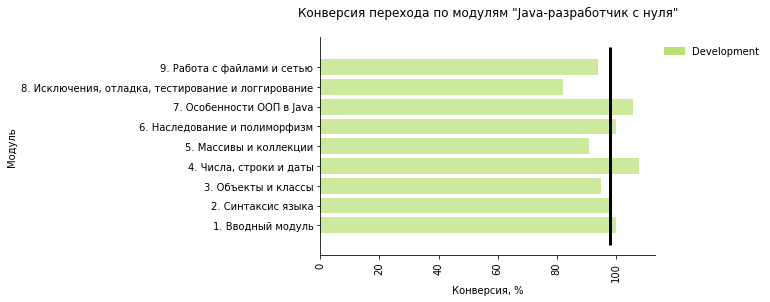

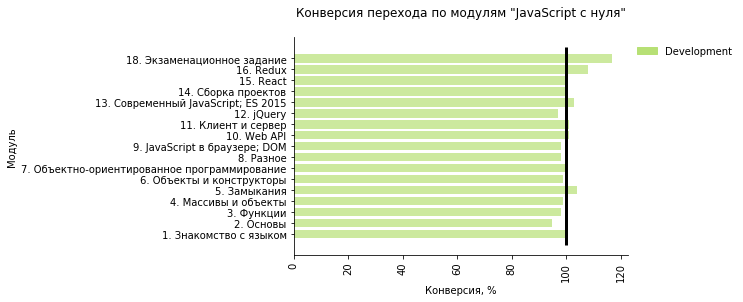

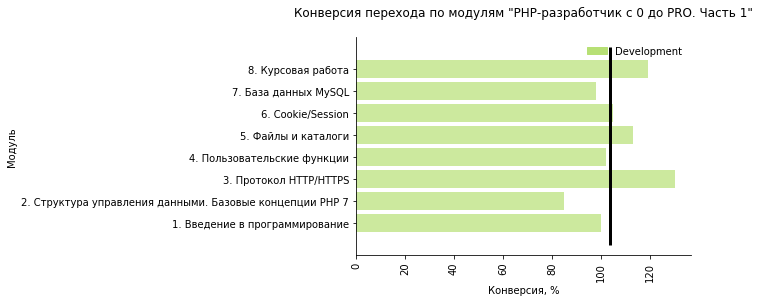

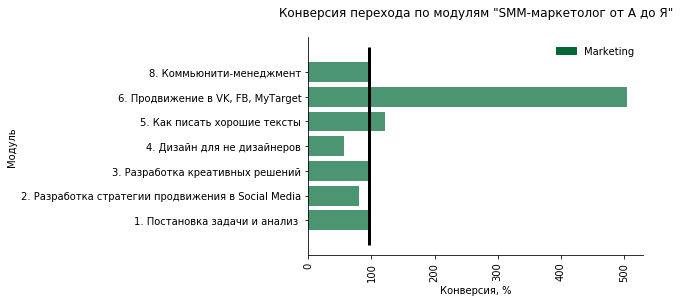

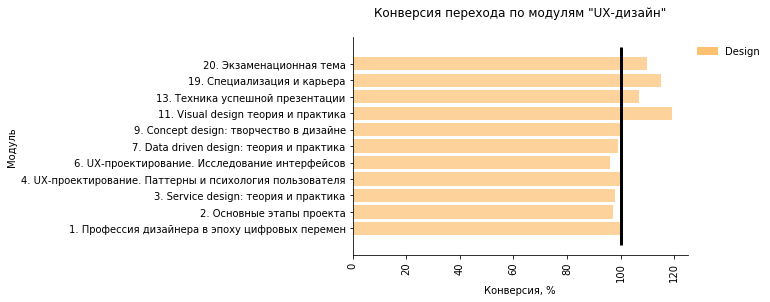

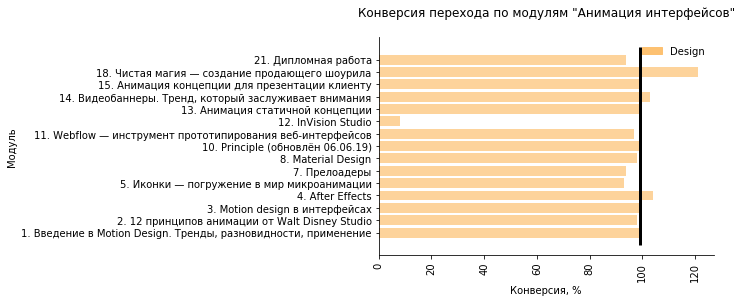

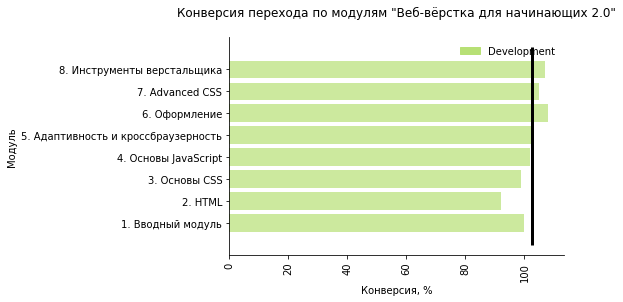

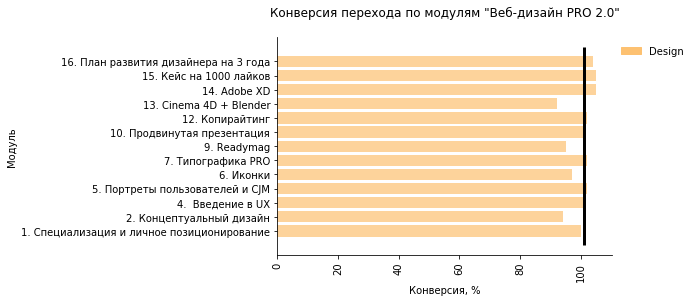

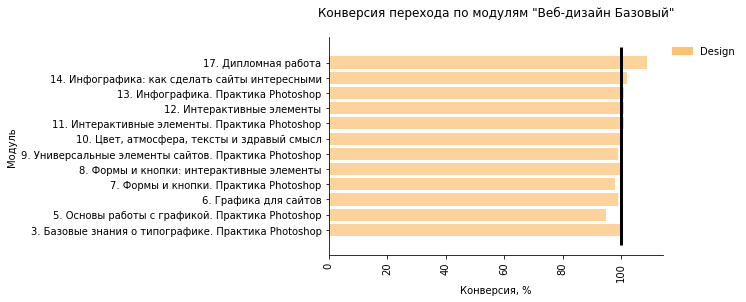

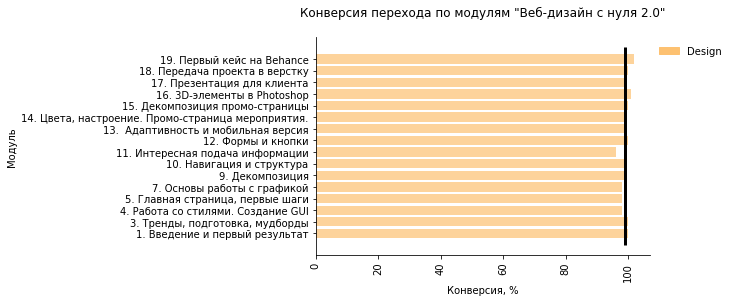

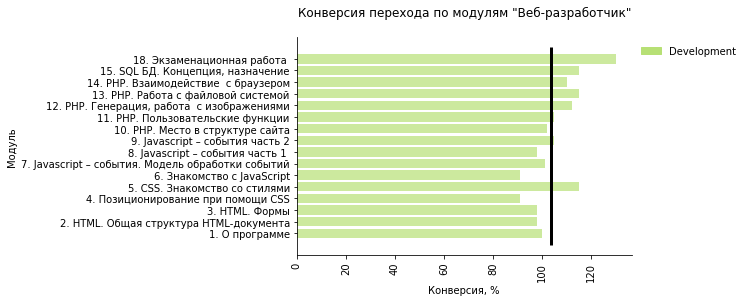

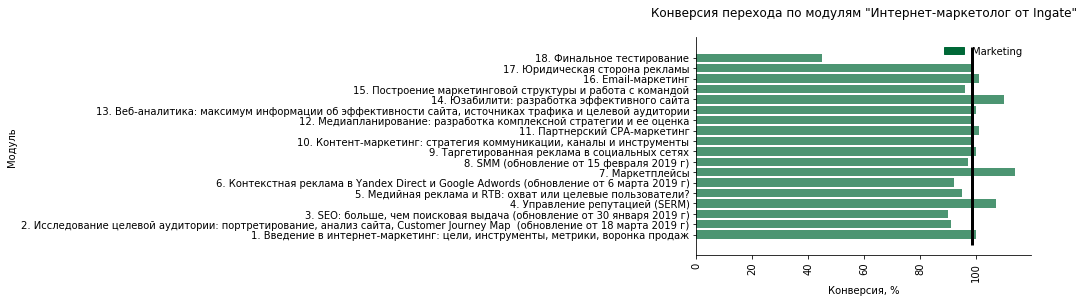

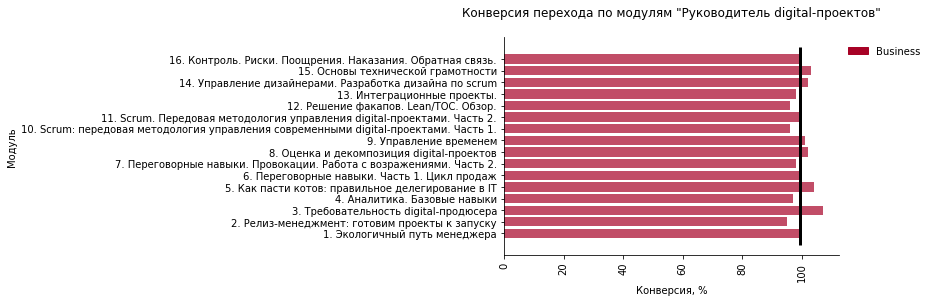

In [116]:
#соберем датасет с необходимыми данными
plot_data = conversion.reset_index().merge(courses.loc[:, ['title', 'field']], how = 'left')
plot_data['module_title'] = plot_data['module_number'].astype(str) + '. ' + plot_data['module_title']

#формируем данные для легенды: категории курсов и цвета для каждой категории
fields = np.unique(main['field'])
colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.005, 0.999, len(fields)))

#создаем словарь, где key = наименование категории курса, value - цвет
category = dict(zip(fields, colors))

#строим график для каждого курса отдельно
for course in np.unique(main['title']):
    data = plot_data[plot_data['title'] == course]
    
    y = data['module_title']
    width = data['сonversion, %']
    
    fig, subplot = plt.subplots()
    plt.xlabel('Конверсия, %')
    plt.ylabel('Модуль')
    subplot.spines['right'].set_visible(False)
    subplot.spines['top'].set_visible(False)
    plt.xticks(rotation=90)

    subplot.set_title(f'Конверсия перехода по модулям "{course}"\n')
    
    #создаем массив, который хранит цвета в зависимости от категории для каждого курса
    c = data['field'].apply(lambda x: category[x])
 
    #наносим столбцы на график    
    plt.barh(y, width, color = c, alpha = 0.7)  #прозрачность 0.1 слишком прозрачно
    
    #наносим линию медианы
    plt.vlines(width.median(), -1, len(y), linewidth = 3)
    
    #формируем подписи для легенды и саму легенду
    legend_label = data['field'].unique()
    handles = [plt.Rectangle((0,0),1,1, color=category[label]) for label in legend_label]
    plt.legend(handles, legend_label, frameon = False, bbox_to_anchor=(1, 1))


### Аналитический отчет: выявление проблемных модулей на основе анализа конверсии

Достаточно часто студенты перескакивают из модуля в модуль, не выполнив домашнее задание. Это может быть связано со сложностью домашнего задания, его объемом и нудностью либо же незаинтересованностью студента в его выполнении. Анализ конверсии перехода студентов из одного модуля в другой позволит выявить проблемные модули на курсах: если конверсия на i-том модуле превышает 100% это означает, что студенты приступили к выполнению нового дз, не выполнив предыдущее, что свидетельствует о существующих недоработках в предшествующих модулях.

На основании имеющейся информации были выделены следующие курсы и их проблемные модули:  
-**`Java-разработчик с нуля`**. Проблемные модули: Наследование и полиморфизм, объекты и классы. Это вполне ожидаемо, т.к. темы модулей довольно сложные и, возможно, у студентов нет мотивации выполнять сложные задания, когда есть более простые. Например, после модуля Объекты и классы следует модуль Числа, строки и даты.

-**`PHP-разработчик с 0 до PRO. Часть 1`**. Медианная конверсия на курсе превышает 100%. Это означает, что половину домашних заданий по модулям студенты начинают, не завершив предыдущие. Здесь из проблемных можно выделить следующие модули: Структура управления данными. Базовые концепции PHP 7 и Пользовательские функции.

-**`SMM-маркетолог от А до Я`**. Конверсия перехода в модуль Продвижение в VK, FB, MyTarget превышает 500%. Это говорит о том, что дз в предшествующем модуле Как писать хорошие тексты студенты не выполнили дз, что свидетельствует о проблемах в модуле.
Анимация интерфейсов. Проблемный модуль: Анимация концепции для презентации клиенту.
